# Predicting Full and Empty Hubway Stations
Harvard CS109 final project, submitted December 2014 

Lauren Alexander, Gabriel Goulet-Langlois, and Joshua Wolff

## Notebook Contents
[0 Introduction](#1)

[1 Data](#1)
  * [1.1 Hubway Data](#1.1)
  * [1.2 Events Data](#1.2)
  * [1.3 Weather Data](#1.3)
  
[2 Analysis](#2)
  * [2.1 Ridership Trends](#2.1)
  * [2.2 Station Trends](#2.2)
  
[3 Prediction](#3)
  * [3.1 Prediction Dataframe](#3.1)
  * [3.2 Baseline](#3.2)
  * [3.3 Classifier Approach](#3.3)
  * [3.4 Bayesian Approach](#3.4)
  * [3.5 Regression Approach - all Stations](#3.5)
  * [3.6 Regression Approach - by Station](#3.6)
  
[4 Conclusions](#4)
  * [4.1 Performance](#4.1)
  * [4.2 Next Steps](#4.2)

All Data used in this project can be accessed from our github repository :
https://github.com/CS109Hubway/classp

# 0 Introduction
<a id = '0'></a>

---

## Project Overview and Related Work
We set out to create an algorithm that could predict the number of available bikes and available docks in each Hubway station 10 to 30 minutes in advance. Armed with this tool, a rider could better plan their journey. An app running this algorithm could inform a prospective rider that a departure station is likely to soon run out of bikes or an arrival station likely to soon run out of docking space. Riders could rely on this tool to plan their trips, improving their experience, and operators could use it to plan rebalancing, improving the Hubway system as a whole. We were not the first to attempt a project such as this: scientists at “Data Science for Social Good” attempted a similar project for Chicago’s bikeshare program, Divvy, although their project was aimed more at helping Divvy rebalance uneven stations than at riders hoping to best plan their routes. You can read about that project here: http://dssg.io/2013/08/09/divvy-helping-chicagos-new-bike-share.html 

## Background and Motivation
Bike sharing programs represent one of the mainstays of the sharing economy. Like other types of sharing programs, such as car-sharing programs, bike shares offer efficiencies that increase economic and environmental welfare. Bike shares offer users access to bicycle transportation without the upfront costs of a private bicycle or maintenance costs. They increase the number of cyclists on the road and decrease the number of drivers, while simultaneously preventing a surplus of unused bicycles from being manufactured.
 
Hubway is Boston’s most successful bike sharing program. The company asks customers to pay a relatively modest annual or monthly fee, and in return gives customers access to bicycles parked at stations across Boston, Brookline, Cambridge, and Somerville. Additionally, 24-hour and 72-hour passes are available for purchase by non-members. Customers can take short rides for free and pay a nominal hourly rate for any journey lasting more than 30 minutes. Typically, riders will pick up a bike from a “dock” in one part of the city and drop it off at another dock.
 
A major challenge for bicycle sharing programs like Hubway is redistribution of resources across the transportation network. Certain bicycle stations are chronically empty at certain times of the day, while others are often full, forcing riders to find another, more inconvenient station at which to drop off the bike. This element of uncertainty detracts from the otherwise seamless user experience. To partially remedy this problem, Hubway uses vans to redistribute the bikes across stations each day. However, this strategy is ad hoc and haphazard. It adds to company costs and moreover detracts from the environmental benefits that Hubway offers.
 
This problem calls for a more scientific approach to both the redistribution of bikes across stations and the provision of information to customers. We propose a new data science program that informs customers of the likelihood that either a bicycle or an empty bike dock will be available at a given station at some future point in time. This will help improve user experience for customers and inform distribution efforts for the Hubway team. 

## Initial Questions
Our study began with a single broad question: what will each Hubway station look like during a given 15 minute interval sometime in the future? It is the nature of data science to force scientists to rethink their questions, and we quickly realized that our initial question was overly broad, difficult to answer, and perhaps not even useful for riders. As the project continued, the questions evolved. Eventually, four primary questions emerged to drive our analysis: 
* How do environmental variables affect the future state of Hubway stations? 
* What do usage patterns look like with respect to specific stations and how that translates to imbalances in the system?
* Can we integrate these explanatory variables and these usage patterns into a predictive algorithm that would predict empty and full stations in the near future?
* What form should that algorithm take? 

The last question shifted late in the project, however, when the results of our analysis indicated that a single style of algorithm might fail to produce solidly dependable results. Ultimately, we concluded the project by asking: What are the strengths and weaknesses of each of our algorithm designs, and how do they point toward a future ensemble prediction method?

## Overview Of Our Process
Hubway ridership trends depend upon time of day, time of year, commute patterns, weather, and events such as sports. We began our study by scraping relevant datasets from the Hubway website as well as websites detailing weather and sports event histories for Boston during 2012. We then performed a series of small exploratory data analyses with the hope of understanding how different variables were associated with one another. These explorations revealed important patterns about Hubway ridership on weekdays vs. weekends, in good weather vs. bad weather, and before and after baseball games. We also incorporated mapping and clustering operations into our exploratory phase: we used simple techniques to identify how location affects station ridership and more complicated techniques such as singular value decomposition to group stations according to temporal use patterns and map them geographically. 

The information collected during the exploration phase informed the creation of three predictive algorithms: one using random forest classification, another using bayesian inference, and third using multiple regression. Each method drew on the data in different ways, and all are discussed in more detail below. For each method, we used a test set of data to determine how well the algorithm performed, in terms of an accuracy measure called recall, against a baseline model that predicted future station status based entirely on station status 15 minutes previously.

In [2]:
#special IPython command to prepare the notebook for matplotlib
%matplotlib inline

#import libraries
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
from statsmodels.nonparametric.api import lowess
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
import sklearn.decomposition
import sklearn.cluster
from matplotlib import gridspec
import seaborn as sns
import datetime

#import python functions that read in each data source
import read_prep 

#set default plot characterstics and colors
from matplotlib import rcParams

#dark_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (12, 9)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="white"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"



# 1 DATA
<a id = '1'></a>

---

For this project, we explored publicly-available data of three different types:
* Hubway data: station, station status, and trips
* weather data: hourly precipitation and temperature
* special events data: Red Sox and Celtics home game schedule

Each of our data sources are described in more detail in the following subsections, including the location, format and scope of the raw data. Due to coverage of the Hubway datasets, we chose to focus our analysis on May through September of 2012. To read in and process each data set, we built functions referenced in read_prep.py. 


## 1.1 Hubway data
<a id = '1.1'></a>

-----

### 1.1.1 Stations

Data about each Hubway station through November 2013 is available http://hubwaydatachallenge.org/. We uploaded this data to our project github page under 'data/hubway_stations.csv'. For each station, the station latitude and longitude are available, as well as the station ID, name, municipality, and status.

In [3]:
#import station data to stations dataframe
stations = read_prep.stations('data/hubway_stations.csv')
stations.head()

id terminal                             station municipal        lat  \
0   3   B32006              Colleges of the Fenway    Boston  42.340021   
1   4   C32000         Tremont St. at Berkeley St.    Boston  42.345392   
2   5   B32012  Northeastern U / North Parking Lot    Boston  42.341814   
3   6   D32000            Cambridge St. at Joy St.    Boston  42.361285   
4   7   A32000                            Fan Pier    Boston  42.353412   

         lng    status  
0 -71.100812  Existing  
1 -71.069616  Existing  
2 -71.090179  Existing  
3 -71.065140  Existing  
4 -71.044624  Existing

### 1.1.2 Trips

Data about each Hubway trip through November 2013 is available http://hubwaydatachallenge.org/. We filtered this data to include only trips taken in 2012 and uploaded it to our project github page under'data/tripsthrough2012.csv'. The fields include start and end station, start and end time to the nearest minute, user type (registered vs occasional), zipcode and sex for registered users, and bike number.

In [5]:
#import trips data to trips dataframe
trips = read_prep.trips('data/tripsthrough2012.csv')
trips.head()

index  seq_id  hubway_id  status  duration          start_date  \
0  140521  140522     157655  Closed       189 2012-03-13 18:31:00   
1  140522  140524     157657  Closed       704 2012-03-15 00:00:00   
2  140523  140523     157656  Closed      1700 2012-03-15 00:00:00   
3  140524  140525     157658  Closed      1411 2012-03-15 00:00:00   
4  140525  140526     157659  Closed       251 2012-03-15 00:03:00   

   strt_statn            end_date  end_statn bike_nr     ...      st_hour  \
0          29 2012-03-13 18:34:00         18  B00094     ...           18   
1          40 2012-03-15 00:12:00         40  B00082     ...            0   
2           7 2012-03-15 00:28:00         15  B00603     ...            0   
3          41 2012-03-15 00:24:00         36  B00278     ...            0   
4          43 2012-03-15 00:07:00         40  B00076     ...            0   

  end_hour  st_minute end_minute  st_month  end_month  st_daydate  \
0       18       1111       1114         3          3  2012-03-13   
1        0          0         12         3          3  2012-03-15   
2        0          0         28         3          3  2012-03-15   
3        0          0         24         3          3  2012-03-15   
4        0          3          7         3          3  2012-03-15   

   end_daydate  st_weekday  end_weekday  
0   2012-03-13           1            1  
1   2012-03-15           3            3  
2   2012-03-15           3            3  
3   2012-03-15           3            3  
4   2012-03-15           3            3  

[5 rows x 24 columns]

### 1.1.3 Station Status

Minute-by-minute data about the status of each Hubway station through September 2012 is available at http://hubwaydatachallenge.org/. The raw data set contains 30 million records, and as such, we used Postgres to summarize station statuses in 5 minute intervals. The SQL code is uploaded to our github project page under 'interval_aggregation.sql', and the processed station status interval data is uploaded under 'data/interval_stationstatus_may_jul.csv' and 'data/interval_stationstatus_aug_sept.csv'

The raw status data includes the hubway station ID, the time to the nearest second, the number of bicycles available, the number of docks available and the total station capacity. The processed data includes total bike arrivals and departures during the 5 minute interval, as well as the number of bikes and capacity at the end of the 5 minute interval.

In [6]:
#import station status data into statusintervals dataframe
statusintervals = read_prep.statusintervals('data/interval_stationstatus_may_jul.csv',
                                            'data/interval_stationstatus_aug_sept.csv')

statusintervals.head()

index     interv  station_id  bike_arrivals  bike_departures  \
0      0 2012-05-01           3              0                0   
1      1 2012-05-01           4              0                0   
2      2 2012-05-01           5              0                0   
3      3 2012-05-01           6              0                0   
4      4 2012-05-01           7              0                0   

   latest_num_bikes  latest_capacity  hour  minute  month     daydate  weekday  
0                 4               15     0       0      5  2012-05-01        1  
1                15               15     0       0      5  2012-05-01        1  
2                10               14     0       0      5  2012-05-01        1  
3                 9               15     0       0      5  2012-05-01        1  
4                 9               15     0       0      5  2012-05-01        1

## 1.2 Events data
<a id = '1.2'></a>

-----

Andrew Desautels' publicly-available Sports Reference Schedule Scraper (https://gist.github.com/drewdez/7b0699c33de967325635) scrapes the relevant Sports Reference site for schedule data associated with home games for a given MLB, NBA, NFL, or NHL team and year, and creates a CSV file with basic game information, including opponent, date, venue, start time, duration, and attendance.

After downloading get_schedule.py, we used the following 2 lines of python code to scrape data for the Red Sox and Celtics 2012 seasons.
* python get_schedule.py MLB BOS 2012 RedSox2012.csv
* python get_schedule.py NBA BOS 2012 Celtics2012.csv

We uploaded the output files to our github project page under 'data/RedSox2012.csv' and 'data/Celtics2012.csv'. Note that there were no home Bruins games between May and September in 2012, so we have not included hockey data in our analysis. 
    

### 1.2.1 Red Sox games


In [7]:
#import baseball data to MLB dataframe
MLB = read_prep.baseball('data/RedSox2012.csv')
MLB.head()

read_prep.py:223: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  MLB = pd.read_csv(url, ', ')


Teams Day of Week      Date  Year     Time        Venue  \
0     Rays at Red Sox      Friday  April 13  2012   2:09PM  Fenway Park   
1     Rays at Red Sox    Saturday  April 14  2012   4:05PM  Fenway Park   
2     Rays at Red Sox      Sunday  April 15  2012   1:38PM  Fenway Park   
3     Rays at Red Sox      Monday  April 16  2012  11:04AM  Fenway Park   
4  Rangers at Red Sox     Tuesday  April 17  2012   7:13PM  Fenway Park   

   Attendance Duration          start_time            end_time  hour  minute  \
0       37032     3:19 2012-04-13 14:09:00 2012-04-13 17:28:00    14       9   
1       38024     3:18 2012-04-14 16:05:00 2012-04-14 19:23:00    16       5   
2       38024     3:12 2012-04-15 13:38:00 2012-04-15 16:50:00    13      38   
3       38108     3:08 2012-04-16 11:04:00 2012-04-16 14:12:00    11       4   
4       38229     3:25 2012-04-17 19:13:00 2012-04-17 22:38:00    19      13   

   month     daydate  weekday  
0      4  2012-04-13        4  
1      4  2012-04-14        5  
2      4  2012-04-15        6  
3      4  2012-04-16        0  
4      4  2012-04-17        1

### 1.2.2 Celtics games

In [8]:
#import basketball data to MLB dataframe
NBA = read_prep.basketball('data/Celtics2012.csv')
NBA.head()

read_prep.py:266: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  NBA = pd.read_csv(url, ', ')


Teams         Date  Year    Time  \
0      Detroit Pistons at Boston Celtics  December 30  2011  7:30PM   
33       Atlanta Hawks at Boston Celtics        May 4  2012  7:30PM   
34       Atlanta Hawks at Boston Celtics        May 6  2012  7:00PM   
35       Atlanta Hawks at Boston Celtics       May 10  2012  8:00PM   
36  Philadelphia 76ers at Boston Celtics       May 12  2012  8:00PM   

        Venue  Attendance Duration          start_time  \
0   TD Garden       18624     2:09 2011-12-30 19:30:00   
33  TD Garden       18624     2:47 2012-05-04 19:30:00   
34  TD Garden       18624     2:17 2012-05-06 19:00:00   
35  TD Garden       18624     2:30 2012-05-10 20:00:00   
36  TD Garden       18624     2:24 2012-05-12 20:00:00   

                     end_time  hour  minute  month     daydate  weekday  
0  2011-12-30 21:39:00.000000    19      30     12  2011-12-30        4  
33 2012-05-04 21:05:25.032704    19      30      5  2012-05-04        4  
34 2012-05-06 21:17:00.000000    19       0      5  2012-05-06        6  
35 2012-05-10 22:30:00.000000    20       0      5  2012-05-10        3  
36 2012-05-12 22:24:00.000000    20       0      5  2012-05-12        5

## 1.3 Weather data
<a id = '1.3'></a>

-----

Weather data (precipitation in inches), snowfall in inches, and temperature in degress Fahrenheit) was scraped from the weathersource.com API for every hour of the 2012 season. 
The weathersource.com API limits the number of lines per query to 24 and the number of queries per minute to 10. To deal with this, we wrote a python function(see "scrape_weather.py") to loop through each day of the 2012 season with a pause of 6 seconds between each day. This allows for the relevant data to be obtained while respecting the weathersource terms of use. The resulting process takes about 20 minutes. The result of each query was saved to a pandas dataframe. This dataframe was exported to a csv which can be loaded directly from our github page.

In [10]:
# Scrape Weather Data using custom function. (Export Results as CSV to GitHub repository)
# import scraping_weather as sw
# sw.scrape_weather(dt.date(2012,5,1),dt.date(2012,9,30))

#import weather data to weather dataframe
weather = read_prep.weather('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/weather.csv')
weather.columns=['index','precip','snowfall','temp','datetime','hour','minute','month','daydate','weekday']
weather.head()


index  precip  snowfall  temp            datetime  hour  minute  month  \
0      0    0.00       0.0  33.6 2012-03-10 00:00:00     0       0      3   
1      1    0.00       0.0  32.7 2012-03-10 01:00:00     1       0      3   
2      2    0.00       0.0  34.6 2012-03-10 02:00:00     2       0      3   
3      3    0.01       0.1  36.6 2012-03-10 03:00:00     3       0      3   
4      4    0.01       0.1  35.4 2012-03-10 04:00:00     4       0      3   

      daydate  weekday  
0  2012-03-10        5  
1  2012-03-10        5  
2  2012-03-10        5  
3  2012-03-10        5  
4  2012-03-10        5

## 2 ANALYSIS
<a id = '2'></a>

-----

In this section of the notebook, we analyze station and staion-pair spatial and temporal trends. By exploring the role of variables like precipitation and baseball games on Hubway station status, we gain insight into key predictors of station emptyness and fullness.

## 2.1 Ridership Trends
<a id = '2.1'></a>

-----

### 2.1.1 Ridership statistics

As a general introduction to the Hubway system it is useful look at the proportion of male, females and unregistered user in the system.

Percent Male Trips :51.7
Percent Female Trips :16.9
Percent Casual :31.4


c:\Users\paul.dong\Documents\Apps\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


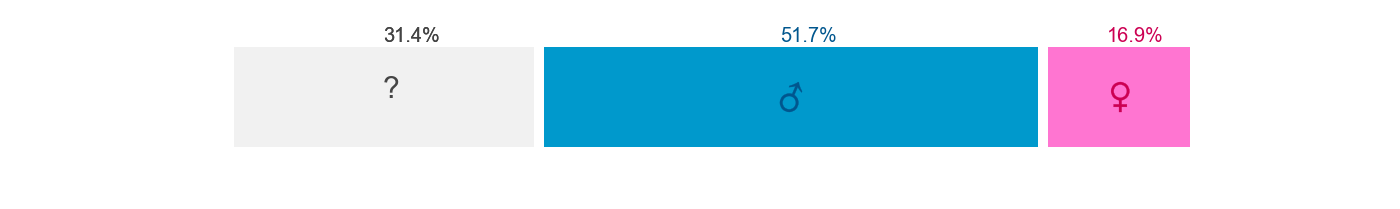

In [11]:
## Unregistered, Male, Female
nbr_trips = trips['seq_id'].count()*1.0
perc_male = trips.groupby('gender')['seq_id'].count()['Male']*100/nbr_trips
perc_female = trips.groupby('gender')['seq_id'].count()['Female']*100/nbr_trips
perc_casual = trips.groupby('subsc_type')['seq_id'].count()['Casual']*100/nbr_trips

print 'Percent Male Trips :' + str(round(perc_male,1))
print 'Percent Female Trips :' + str(round(perc_female,1))
print 'Percent Casual :' + str(round(perc_casual,1))


## PLot Gender and Registration Bar
plt.figure(figsize=(24,3));
ax = plt.gca();
ax.grid(False);
ax.patch.set_visible(False);
plt.axis('off');
plt.plot([0, perc_casual], [5, 5], linewidth=100, 
         linestyle="-", c="#F1F1F1",solid_capstyle="butt");
plt.plot([perc_casual+1, 1+perc_male+perc_casual], [5, 5], linewidth=100, 
         linestyle="-", c="#0099CC",solid_capstyle="butt");
plt.plot([2+perc_male+perc_casual, perc_male+perc_casual+perc_female], [5, 5], 
         linewidth=100, linestyle="-", c='#FF75D1',solid_capstyle="butt");

plt.scatter(1+perc_male/2+perc_casual,5,900,zorder=4,marker=ur'$\u2642$',color='#00568E');
plt.scatter(1+perc_male+perc_casual+perc_female/2,5,900,zorder=4,marker=ur'$\u2640$', color='#CC0052');
plt.annotate(str(round(perc_casual,1))+"%", xy=(perc_casual/2,5.02),size=20)
plt.annotate(str(round(perc_male,1))+"%", xy=(perc_casual+perc_male/2,5.02),size=20,color='#00568E')
plt.annotate(str(round(perc_female,1))+"%", xy=(perc_casual+perc_male+perc_female/2,5.02),size=20,color='#CC0052')
plt.annotate(str(round(perc_casual,1))+"%", xy=(perc_casual/2,5.02),size=20)
plt.annotate("?", xy=(perc_casual/2,5),size=30);



### 2.1.2 Trip Duration Distribution
In order to inform the prediction window it is useful to consider the distribution of trip durations.

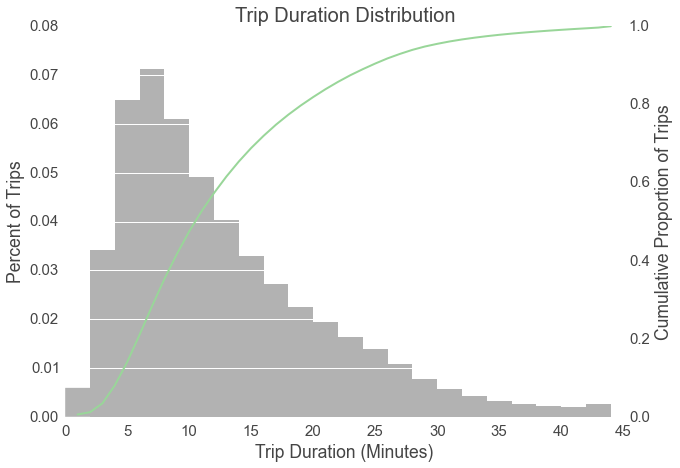

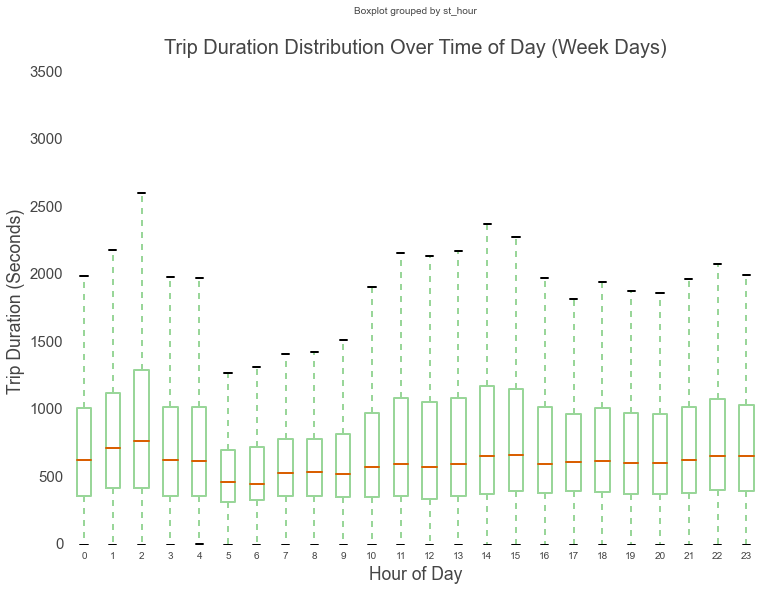

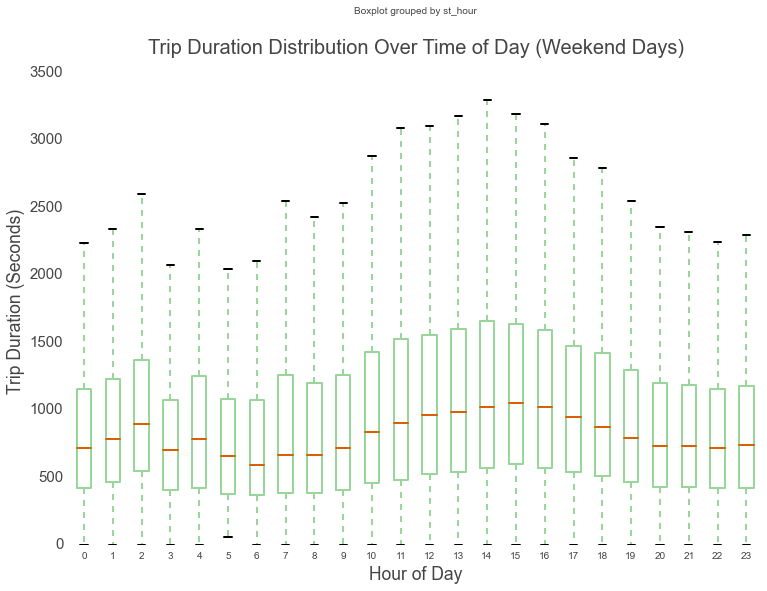

In [12]:
# Trip Duration Distribution
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.grid(zorder=1)
ax1.xaxis.grid(False)
trip_dur = trips['duration'].values/60
plt.hist(trip_dur, bins = range(0,45,2),normed=True,zorder=0,color=dark_colors[1])
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Percent of Trips')
plt.title('Trip Duration Distribution')

# Compute Cumulative Distribution
hist, bin_edges = np.histogram(trip_dur, range(0,45,1), normed=True)
cum_trip_dur = np.cumsum(hist)
ax2 = ax1.twinx();
ax2.plot(range(1,45,1),cum_trip_dur,c=dark_colors[0]);
ax2.set_ylabel('Cumulative Proportion of Trips');
ax2.grid(b=False);


# Examine the Distribution of Trip Duration over different times of day and days of week
trips['week']=trips.st_weekday < 5
trips.loc[(trips.duration <= 7200) & (trips.week ==True)].boxplot(column='duration',by='st_hour');
plt.ylim(0,3600);
plt.ylabel('Trip Duration (Seconds)');
plt.xlabel('Hour of Day');
plt.title('Trip Duration Distribution Over Time of Day (Week Days)');
 
plt.figure;
trips.loc[(trips.duration <= 7200) & (trips.week ==False)].boxplot(column='duration',by='st_hour');
plt.ylim(0,3600);
plt.ylabel('Trip Duration (Seconds)');
plt.xlabel('Hour of Day');
plt.title('Trip Duration Distribution Over Time of Day (Weekend Days)');

### 2.1.3 Weather
Another important factor influencing hubway ridership relates to weather. We examine the impact of rain and temperature on ridership. 

As shown in the figure below, rain causes an important drop in ridership. The figure comparing the impact of rain on weekdays vs week-ends also demontrates that the relative impact of rain is even more considerable on week-ends where a larger proportion of trips are leisurly and can hence be forgone. 

The effect of temperature is 2 fold. At temperatures below $75 ^oF$ ridership increases with increasing temperature. This is likely driven by both longer-term seasonal effects, and short-term factors. In the long-run, as the spring progresses riders increasingly consider using  hubway inline with the sustain improvement in weather conditions. In the short-run, users may choose not to ride hubway on colder days, or may prefer to enjoy the benefits of cycling on particularly nice weather days. 
For days with mean temperatures above $75 ^oF$ average daily ridership decreases probably due to the incomfort of riding in very hot weather. Interestingly, the effect of hot weather not noticeable on an hourly basis. This may indicate that the decision is not to bike because of hot weather is taken for the day as whole. For example, a user may choose not to bike at 8 am when the temprature is comfortable, knowing the temperature is forcasted to increase later in the day.

In [18]:
pd.set_option("display.max_columns", 30)

In [19]:
trips.head()

index  seq_id  hubway_id  status  duration          start_date  \
0  140521  140522     157655  Closed       189 2012-03-13 18:31:00   
1  140522  140524     157657  Closed       704 2012-03-15 00:00:00   
2  140523  140523     157656  Closed      1700 2012-03-15 00:00:00   
3  140524  140525     157658  Closed      1411 2012-03-15 00:00:00   
4  140525  140526     157659  Closed       251 2012-03-15 00:03:00   

   strt_statn            end_date  end_statn bike_nr  subsc_type zip_code  \
0          29 2012-03-13 18:34:00         18  B00094  Registered   '02446   
1          40 2012-03-15 00:12:00         40  B00082  Registered   '02109   
2           7 2012-03-15 00:28:00         15  B00603  Registered   '02478   
3          41 2012-03-15 00:24:00         36  B00278  Registered   '02116   
4          43 2012-03-15 00:07:00         40  B00076  Registered   '02109   

   birth_date  gender  st_hour  end_hour  st_minute  end_minute  st_month  \
0        1988  Female       18        18       1111        1114         3   
1        1976  Female        0         0          0          12         3   
2        1983    Male        0         0          0          28         3   
3        1991    Male        0         0          0          24         3   
4        1984  Female        0         0          3           7         3   

   end_month  st_daydate end_daydate  st_weekday  end_weekday  week  
0          3  2012-03-13  2012-03-13           1            1  True  
1          3  2012-03-15  2012-03-15           3            3  True  
2          3  2012-03-15  2012-03-15           3            3  True  
3          3  2012-03-15  2012-03-15           3            3  True  
4          3  2012-03-15  2012-03-15           3            3  True

In [26]:
# Group Trips by Hour of the Day and Weekday vs Week-end Day
trip_g = trips.groupby(['st_daydate', 'st_hour'])
trip_hour = pd.DataFrame({'ridership':trip_g['hubway_id'].count(), 'weekday':trip_g['st_weekday'].median()})

In [27]:
trip_hour.head()

ridership  weekday
st_daydate st_hour                    
2012-03-13 18               1        1
2012-03-15 0                9        3
           1                1        3
           6                9        3
           7               22        3

In [20]:
weather.head()

index  precip  snowfall  temp            datetime  hour  minute  month  \
0      0    0.00       0.0  33.6 2012-03-10 00:00:00     0       0      3   
1      1    0.00       0.0  32.7 2012-03-10 01:00:00     1       0      3   
2      2    0.00       0.0  34.6 2012-03-10 02:00:00     2       0      3   
3      3    0.01       0.1  36.6 2012-03-10 03:00:00     3       0      3   
4      4    0.01       0.1  35.4 2012-03-10 04:00:00     4       0      3   

      daydate  weekday  
0  2012-03-10        5  
1  2012-03-10        5  
2  2012-03-10        5  
3  2012-03-10        5  
4  2012-03-10        5

In [28]:
# Merge Weather and Trip Information. 
trip_weather = pd.merge(trip_hour, weather, how='left', left_index=True, right_on=['daydate', 'hour'])

In [30]:
trip_weather.reset_index(inplace=True)
trip_weather.drop('weekday_y',axis=1,inplace=True)
trip_weather.columns=['level_0','ridership','weekday','index','precip','snowfall','temp','datetime','hour','minute','month','daydate']

In [32]:
# Compute Weekday Binary and Precipitation Binary variable
trip_weather['week']=trip_weather.weekday < 5
trip_weather['precip_binary']=trip_weather.precip > 0

In [33]:
# Merge Weather and Trip Information. 
trip_weather.head()

level_0  ridership  weekday  index  precip  snowfall  temp  \
0       90          1        1     90       0         0  64.5   
1      120          9        3    120       0         0  39.2   
2      121          1        3    121       0         0  38.9   
3      126          9        3    126       0         0  38.6   
4      127         22        3    127       0         0  38.8   

             datetime  hour  minute  month     daydate  week precip_binary  
0 2012-03-13 18:00:00    18       0      3  2012-03-13  True         False  
1 2012-03-15 00:00:00     0       0      3  2012-03-15  True         False  
2 2012-03-15 01:00:00     1       0      3  2012-03-15  True         False  
3 2012-03-15 06:00:00     6       0      3  2012-03-15  True         False  
4 2012-03-15 07:00:00     7       0      3  2012-03-15  True         False

In [34]:
# Aggregate all Days of 2012 seaon to compute hourly averages
hourly_avgs = trip_weather.groupby(['week','precip_binary','hour'])['ridership'].mean()

In [35]:
hourly_avgs

week   precip_binary  hour
False  False          0        35.937500
                      1        41.588235
                      2        38.367647
                      3         7.716418
                      4         3.888889
                      5         4.216667
                      6         8.184615
                      7        17.885714
                      8        35.757143
                      9        64.176471
                      10       94.283582
                      11      134.696970
                      12      164.136364
                      13      178.582090
                      14      187.846154
                      15      193.015625
                      16      183.538462
                      17      166.015625
                      18      133.253968
                      19      102.352941
                      20       67.701493
                      21       57.937500
                      22       49.079365
                      23      

In [37]:
x = hourly_avgs.loc[True,False].index.values
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

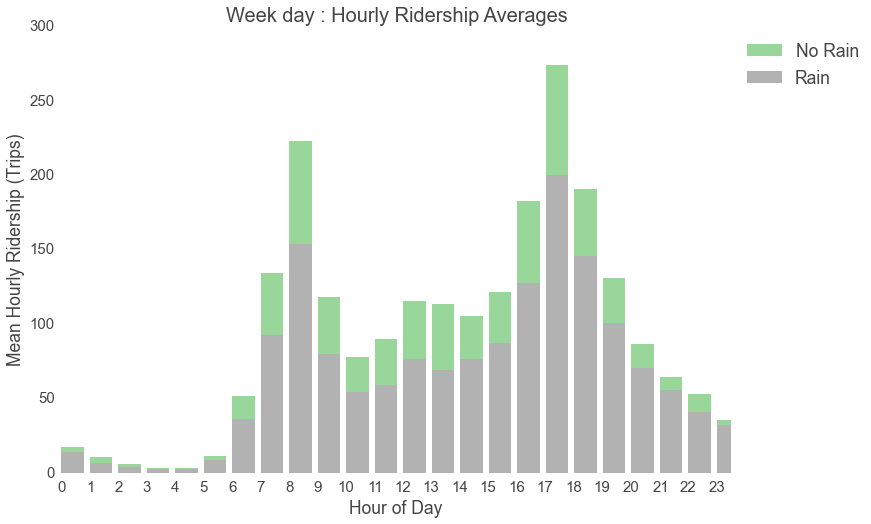

In [38]:
# Effect of Rain on Weekdays
plt.figure(figsize=(12,8))
x = hourly_avgs.loc[True,False].index.values
no_rain = plt.bar(x, hourly_avgs.loc[True,False].values, color=dark_colors[0], width=0.8)
rain = plt.bar(x, hourly_avgs.loc[True,True].values, color=dark_colors[1], width=0.8)
plt.xticks( np.arange(25) )
plt.title('Week day : Hourly Ridership Averages')
plt.ylabel('Mean Hourly Ridership (Trips)')
plt.xlabel('Hour of Day')
plt.xlim(0,23.5)
plt.legend((no_rain,rain),('No Rain', 'Rain'), bbox_to_anchor=(1, 1), loc=2)

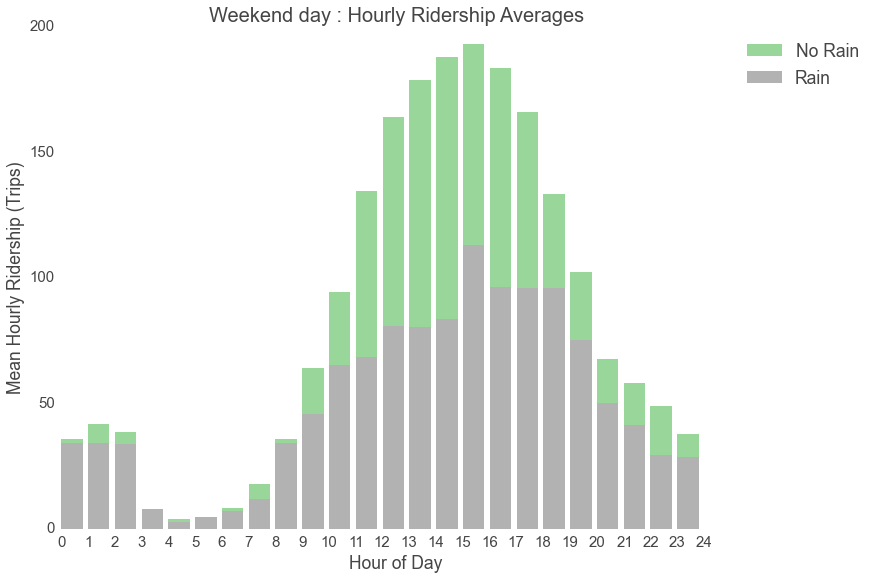

In [39]:
# Effect of Rain on Weekendays
plt.figure()
x = hourly_avgs.loc[False,False].index
no_rain_we = plt.bar(x, hourly_avgs.loc[False,False].values, color=dark_colors[0])
rain_we = plt.bar(x, hourly_avgs.loc[False,True].values, color=dark_colors[1])
plt.xticks( np.arange(25) )
plt.title('Weekend day : Hourly Ridership Averages')
plt.ylabel('Mean Hourly Ridership (Trips)')
plt.xlabel('Hour of Day')
plt.legend((no_rain_we,rain_we),('No Rain', 'Rain'), bbox_to_anchor=(1, 1), loc=2)

In [41]:
# Effect of Temperature on Ridership (DAILY)
weather_g = weather.groupby('daydate')
weather_day = pd.DataFrame( [weather_g.precip.sum(), weather_g.temp.mean(), weather_g.snowfall.sum()]).transpose()
days = weather_day
days['nbr_trips'] = trips.groupby('st_daydate')['st_daydate'].count()

In [42]:
days.head()

precip       temp  snowfall  nbr_trips
daydate                                           
2012-03-10    0.08  33.354167       0.9        NaN
2012-03-11    0.00  38.266667       0.0        NaN
2012-03-12    0.00  50.933333       0.0        NaN
2012-03-13    0.00  55.975000       0.0          1
2012-03-14    0.17  51.020833       0.0        NaN

In [43]:
dark_colors

['#99D699',
 '#B2B2B2',
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

In [44]:
lowess?

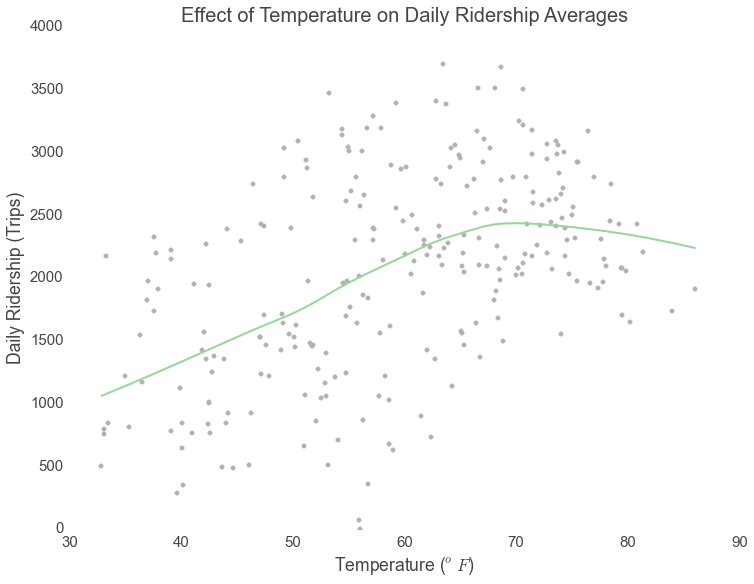

In [45]:
plt.figure()
plt.scatter(days.temp,days.nbr_trips,color=dark_colors[1])
Lowesstrips = lowess(days.nbr_trips,days.temp,frac=0.66)
plt.ylim(0,4000)
plt.title('Effect of Temperature on Daily Ridership Averages')
plt.ylabel('Daily Ridership (Trips)')
plt.xlabel('Temperature ($^oF$)')
plt.plot(Lowesstrips[:,0], Lowesstrips[:,1], color=dark_colors[0])

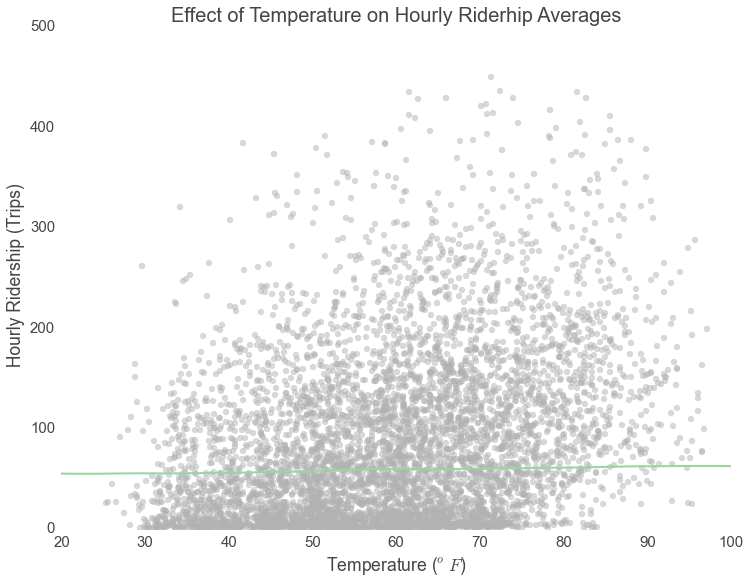

In [48]:
# Effect of Temperature on Ridership (Houlry)
plt.figure()
plt.scatter(trip_weather.temp, trip_weather.ridership, s = 35, alpha=0.5,color=dark_colors[1])
Lowesstrips = lowess(trip_weather.temp, trip_weather.ridership, frac = 0.1)
plt.xlim(20,100)
plt.ylim(0,500)
plt.title('Effect of Temperature on Hourly Riderhip Averages')
plt.xlabel('Temperature ($^oF$)')
plt.ylabel(' Hourly Ridership (Trips)')
plt.plot(Lowesstrips[:,0], Lowesstrips[:,1], color=dark_colors[0]);

### 2.1.4 Special Events

How does ridership change at stations located near special events? The following analysis illustrates the impact of Red Sox games on trip departures at the 4 Hubway stations nearest Fenway Park. On game days there is a sharp increase in the number of average trip departures from Fenway Hubway stations between 9 pm and midnight. Note that the majority of Red Sox games start around 7 pm and end around 10 pm, which appears consistent with this analysis. This finding motivates the incorporation of special events data in station status prediction.

In [51]:
####ridership trends of Fenway stations on Red Sox game days and off days

#get trips during the 2012 baseball season...4/13 through 9/26
tripsMLB = trips[(trips['start_date']>'2012-04-13') & (trips['end_date']<'2012-9-27')]

In [52]:
tripsMLB.head()

index  seq_id  hubway_id  status  duration          start_date  \
28777  169298  169299     192386  Closed       653 2012-04-13 00:02:00   
28778  169299  169300     192387  Closed       511 2012-04-13 00:02:00   
28779  169300  169301     192390  Closed       228 2012-04-13 00:04:00   
28780  169301  169302     192391  Closed       536 2012-04-13 00:04:00   
28781  169302  169303     192392  Closed       249 2012-04-13 00:07:00   

       strt_statn            end_date  end_statn bike_nr  subsc_type zip_code  \
28777          49 2012-04-13 00:13:00         52  B00081  Registered   '02116   
28778          49 2012-04-13 00:11:00         60  B00204  Registered   '02114   
28779          44 2012-04-13 00:08:00         38  B00313  Registered   '01844   
28780          65 2012-04-13 00:13:00         65  B00431      Casual      NaN   
28781          33 2012-04-13 00:11:00         32  B00131  Registered   '02215   

       birth_date gender  st_hour  end_hour  st_minute  end_minute  st_month  \
28777        1983   Male        0         0          2          13         4   
28778        1981   Male        0         0          2          11         4   
28779        1963   Male        0         0          4           8         4   
28780         NaN    NaN        0         0          4          13         4   
28781        1991   Male        0         0          7          11         4   

       end_month  st_daydate end_daydate  st_weekday  end_weekday  week  
28777          4  2012-04-13  2012-04-13           4            4  True  
28778          4  2012-04-13  2012-04-13           4            4  True  
28779          4  2012-04-13  2012-04-13           4            4  True  
28780          4  2012-04-13  2012-04-13           4            4  True  
28781          4  2012-04-13  2012-04-13           4            4  True

In [54]:
#pull trips starting or ending at the fenway stations
fenwaystations = [32,33,45,101]
fenwayorig_wd = tripsMLB[(tripsMLB['strt_statn'].isin(fenwaystations)) & (tripsMLB['st_weekday']<5)]

In [55]:
#get dataframes for days with and without an MLB game
days =MLB['start_time'].map(lambda t: t.date()).values.tolist()
fenwayorig_wd_game = fenwayorig_wd[fenwayorig_wd['st_daydate'].isin(days)]
fenwayorig_wd_off = fenwayorig_wd[-fenwayorig_wd['st_daydate'].isin(days)]

In [57]:
fenwayorig_wd_game.head()

index  seq_id  hubway_id  status  duration          start_date  \
28781  169302  169303     192392  Closed       249 2012-04-13 00:07:00   
28783  169304  169305     192394  Closed       265 2012-04-13 00:25:00   
28806  169327  169328     192421  Closed       404 2012-04-13 05:55:00   
28810  169331  169332     192425  Closed       175 2012-04-13 06:10:00   
28828  169349  169350     192443  Closed       629 2012-04-13 06:41:00   

       strt_statn            end_date  end_statn bike_nr  subsc_type zip_code  \
28781          33 2012-04-13 00:11:00         32  B00131  Registered   '02215   
28783          32 2012-04-13 00:29:00         33  B00157  Registered   '02215   
28806          45 2012-04-13 06:02:00         57  B00010      Casual      NaN   
28810          32 2012-04-13 06:13:00         11  B00162  Registered   '02148   
28828          33 2012-04-13 06:52:00         16  B00555  Registered   '02215   

       birth_date gender  st_hour  end_hour  st_minute  end_minute  st_month  \
28781        1991   Male        0         0          7          11         4   
28783        1991   Male        0         0         25          29         4   
28806         NaN    NaN        5         6        355         362         4   
28810        1969   Male        6         6        370         373         4   
28828         NaN   Male        6         6        401         412         4   

       end_month  st_daydate end_daydate  st_weekday  end_weekday  week  
28781          4  2012-04-13  2012-04-13           4            4  True  
28783          4  2012-04-13  2012-04-13           4            4  True  
28806          4  2012-04-13  2012-04-13           4            4  True  
28810          4  2012-04-13  2012-04-13           4            4  True  
28828          4  2012-04-13  2012-04-13           4            4  True

In [63]:
#group by hour and sum total number of trips by hour
out_wd_game= fenwayorig_wd_game.groupby('st_hour')['seq_id'].count()
out_wd_off= fenwayorig_wd_off.groupby('st_hour').count().seq_id

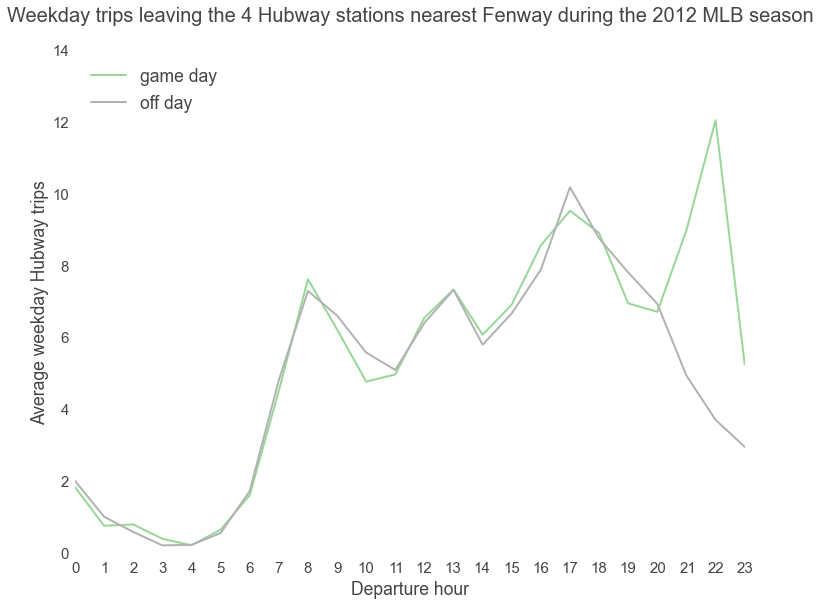

In [64]:
#group by date and get total number of days
wd_game_days = len(fenwayorig_wd_game.groupby('st_daydate'))
wd_off_days = len(fenwayorig_wd_off.groupby('st_daydate'))

#plot average number of trips per hour for weekday game days and offdays
plt.title('Weekday trips leaving the 4 Hubway stations nearest Fenway during the 2012 MLB season', y=1.05);
plt.xlabel('Departure hour');
plt.ylabel('Average weekday Hubway trips');
plt.xticks(np.arange(0, 25, 1));
plt.plot(np.arange(0, 24, 1),out_wd_game/wd_game_days, color=dark_colors[0]);
plt.plot(np.arange(0, 24, 1),out_wd_off/wd_off_days, color=dark_colors[1]);
plt.legend(['game day', 'off day'], loc='upper left');

### 2.1.5 Spatial Distribution

Hubway trips are not distributed uniformly across the city. Instead, a small number station pairs contribute much of the system ridership. Furthermore, ridership patterns vary significantly between weekdays and weekends. The following analysis illustrates the spatial trends for weekday and weekend trips during the period of interest (5/1/2012-9/30/2012).


In [65]:
#function reads in dataframes of weekend and weekday trips and plots them on a map

#note: the user must install Basemap locally prior to running this function.
#This can be done by typing 'conda install basemap' into the Anaconda terminal.

def tripmap(trips):
    
    #create dataframe for weekend and weekday trips between may and sept 2012
    tripsfilt=  trips.loc[trips.st_month >= 5 ]
    tripsfilt=  tripsfilt.loc[tripsfilt.end_month <10 ]

    #number compute trips for weekends and weekdays 
    weekend=  tripsfilt.loc[tripsfilt.st_weekday >=5 ]
    weekend= weekend.groupby(['strt_statn','end_statn'],as_index=False)['seq_id'].count()
    weekend=weekend.sort('seq_id')
    weekday=  tripsfilt.loc[tripsfilt.st_weekday <5 ]
    weekday= weekday.groupby(['strt_statn','end_statn'],as_index=False)['seq_id'].count()
    weekday=weekday.sort('seq_id')

    #plot weekday trips
    plt.subplots(1,2,figsize=(19,12))   
    plt.subplot(1, 2, 1)
    #use mercator projection and set latitude and longitude bounds
    m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.327, urcrnrlon=-71.035, urcrnrlat=42.378, resolution='c')
    m.drawmapboundary(fill_color='#F5F5F5', linewidth=0)
    #show coastline for spatial context
    m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5') 
    poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)

    #loop through weekday trips
    for i in range(len(weekday)):
        #get start and end station
        s_station=weekday.iloc[i].strt_statn
        e_station=weekday.iloc[i].end_statn
        
        #set line width and transparency for plotting based on magnitude of trips
        tripsize=weekday.iloc[i].seq_id *1.0 / weekday.seq_id.max()*10 #lineweight (maxsize = 10)
        colratio=weekday.iloc[i].seq_id *1.0 / weekday.seq_id.max()*0.75 #transparency (maxalpha=0.75)
        
        #get lat and long of start and end stations, add to lists of lat/lon and convert to coordinate system
        s_lat=np.array(stations[stations['id']==s_station].lat)
        e_lat=np.array(stations[stations['id']==e_station].lat)
        s_lon=np.array(stations[stations['id']==s_station].lng)
        e_lon=np.array(stations[stations['id']==e_station].lng)
        lonlist=[s_lon[0], e_lon[0]]
        latlist=[s_lat[0], e_lat[0]]
        x,y = m(lonlist,latlist) #converts lat and lon to x and y coordinates based on projection of m
        
        #plot
        m.plot( x, y, color=dark_colors[0], lw=tripsize,alpha=colratio) 
        plt.title('Weekday Hubway Trips')
    
    #plot weekend trips
    plt.subplot(1, 2, 2)
    m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.327, urcrnrlon=-71.035, urcrnrlat=42.378, resolution='c')
    m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    m.drawmapboundary(fill_color='#F5F5F5', linewidth=0)
    poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)

    for i in range(len(weekend)):
        s_station=weekend.iloc[i].strt_statn
        e_station=weekend.iloc[i].end_statn
        tripsize=weekend.iloc[i].seq_id *1.0 / weekend.seq_id.max()*10
        colratio=weekend.iloc[i].seq_id *1.0 / weekend.seq_id.max()*1
        s_lat=np.array(stations[stations['id']==s_station].lat)
        e_lat=np.array(stations[stations['id']==e_station].lat)
        s_lon=np.array(stations[stations['id']==s_station].lng)
        e_lon=np.array(stations[stations['id']==e_station].lng)
        lonlist=[s_lon[0], e_lon[0]]
        latlist=[s_lat[0], e_lat[0]]
        x,y = m(lonlist,latlist)
        m.plot( x, y, color=dark_colors[0], lw=tripsize,alpha=colratio) 
        plt.title('Weekend Hubway Trips')

    return plt.show()

c:\Users\paul.dong\Documents\Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
c:\Users\paul.dong\Documents\Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


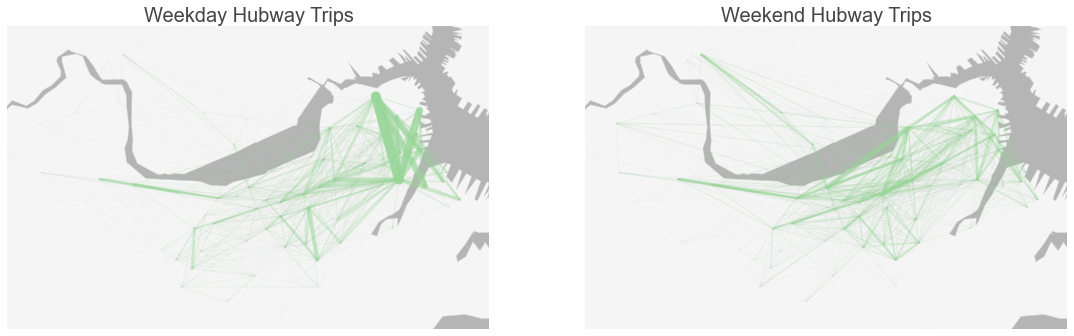

In [66]:
#plot weekend and weekday trips by calling tripmap function
tripmap(trips)

In [67]:
#function reads in dataframes of weekend and weekday trips and plots them on a map

#note: the user must install Basemap locally prior to running this function.
#This can be done by typing 'conda install basemap' into the Anaconda terminal.

    
#create dataframe for weekend and weekday trips between may and sept 2012
tripsfilt=  trips.loc[trips.st_month >= 5 ]
tripsfilt=  tripsfilt.loc[tripsfilt.end_month <10 ]

In [68]:
tripsfilt.head()

index  seq_id  hubway_id  status  duration          start_date  \
58936  199457  199458     227945  Closed      2375 2012-05-01 00:01:00   
58937  199458  199459     227946  Closed       143 2012-05-01 00:02:00   
58938  199459  199460     227947  Closed       290 2012-05-01 00:04:00   
58939  199460  199462     227949  Closed       986 2012-05-01 00:07:00   
58940  199461  199461     227948  Closed      1038 2012-05-01 00:07:00   

       strt_statn            end_date  end_statn bike_nr  subsc_type zip_code  \
58936          55 2012-05-01 00:41:00         61  B00206      Casual      NaN   
58937          22 2012-05-01 00:04:00         43  B00070  Registered   '02110   
58938          48 2012-05-01 00:09:00          6  B00438  Registered   '02114   
58939          59 2012-05-01 00:24:00         21  B00221      Casual      NaN   
58940          59 2012-05-01 00:24:00         21  B00428      Casual      NaN   

       birth_date gender  st_hour  end_hour  st_minute  end_minute  st_month  \
58936         NaN    NaN        0         0          1          41         5   
58937        1988   Male        0         0          2           4         5   
58938        1984   Male        0         0          4           9         5   
58939         NaN    NaN        0         0          7          24         5   
58940         NaN    NaN        0         0          7          24         5   

       end_month  st_daydate end_daydate  st_weekday  end_weekday  week  
58936          5  2012-05-01  2012-05-01           1            1  True  
58937          5  2012-05-01  2012-05-01           1            1  True  
58938          5  2012-05-01  2012-05-01           1            1  True  
58939          5  2012-05-01  2012-05-01           1            1  True  
58940          5  2012-05-01  2012-05-01           1            1  True

In [69]:
#number compute trips for weekends and weekdays 
weekend=  tripsfilt.loc[tripsfilt.st_weekday >=5 ]
weekend= weekend.groupby(['strt_statn','end_statn'],as_index=False)['seq_id'].count()

In [72]:
weekend.head()

strt_statn  end_statn  seq_id
4281          66          7       1
1483          24         72       1
5695          94         50       1
5696          94         52       1
648           12         35       1

In [71]:
weekend=weekend.sort('seq_id')

c:\Users\paul.dong\Documents\Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [73]:
weekday=  tripsfilt.loc[tripsfilt.st_weekday <5 ]
weekday= weekday.groupby(['strt_statn','end_statn'],as_index=False)['seq_id'].count()
weekday=weekday.sort('seq_id')

c:\Users\paul.dong\Documents\Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


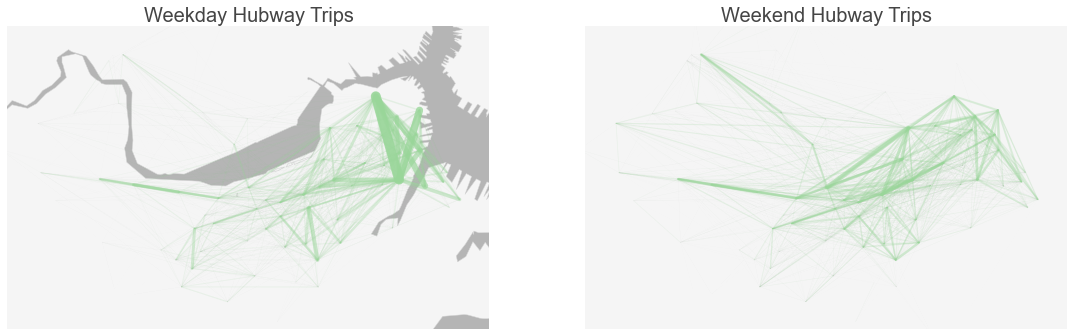

In [79]:
#plot weekday trips
plt.subplots(1,2,figsize=(19,12))   
plt.subplot(1, 2, 1)
#use mercator projection and set latitude and longitude bounds
m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.327, urcrnrlon=-71.035, urcrnrlat=42.378, resolution='c')
m.drawmapboundary(fill_color='#F5F5F5', linewidth=0)
#show coastline for spatial context
m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5') 
poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
plt.gca().add_patch(poly)

#loop through weekday trips
for i in range(len(weekday)):
    #get start and end station
    s_station=weekday.iloc[i].strt_statn
    e_station=weekday.iloc[i].end_statn

    #set line width and transparency for plotting based on magnitude of trips
    tripsize=weekday.iloc[i].seq_id *1.0 / weekday.seq_id.max()*10 #lineweight (maxsize = 10)
    colratio=weekday.iloc[i].seq_id *1.0 / weekday.seq_id.max()*0.75 #transparency (maxalpha=0.75)

    #get lat and long of start and end stations, add to lists of lat/lon and convert to coordinate system
    s_lat=np.array(stations[stations['id']==s_station].lat)
    e_lat=np.array(stations[stations['id']==e_station].lat)
    s_lon=np.array(stations[stations['id']==s_station].lng)
    e_lon=np.array(stations[stations['id']==e_station].lng)
    lonlist=[s_lon[0], e_lon[0]]
    latlist=[s_lat[0], e_lat[0]]
    x,y = m(lonlist,latlist) #converts lat and lon to x and y coordinates based on projection of m

    #plot
    m.plot( x, y, color=dark_colors[0], lw=tripsize,alpha=colratio) 
    plt.title('Weekday Hubway Trips')

#plot weekend trips
plt.subplot(1, 2, 2)
m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.327, urcrnrlon=-71.035, urcrnrlat=42.378, resolution='c')
#m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
m.drawmapboundary(fill_color='#F5F5F5', linewidth=0)
#poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
#plt.gca().add_patch(poly)

for i in range(len(weekend)):
    s_station=weekend.iloc[i].strt_statn
    e_station=weekend.iloc[i].end_statn
    tripsize=weekend.iloc[i].seq_id *1.0 / weekend.seq_id.max()*10
    colratio=weekend.iloc[i].seq_id *1.0 / weekend.seq_id.max()*1
    s_lat=np.array(stations[stations['id']==s_station].lat)
    e_lat=np.array(stations[stations['id']==e_station].lat)
    s_lon=np.array(stations[stations['id']==s_station].lng)
    e_lon=np.array(stations[stations['id']==e_station].lng)
    lonlist=[s_lon[0], e_lon[0]]
    latlist=[s_lat[0], e_lat[0]]
    x,y = m(lonlist,latlist)
    m.plot( x, y, color=dark_colors[0], lw=tripsize,alpha=colratio) 
    plt.title('Weekend Hubway Trips')

plt.show()

## 2.2 Station Trends
<a id = '2.2'></a>

-----

### 2.2.1 Arrivals and Departures

Hubway trips are not distributed uniformly across the city. Instead, a small number station pairs contribute much of the system ridership. As a result of this asymmetry, certain stations have many more incoming and outgoing trips than others. Furthermore, the number of incoming and outgoing trips varies significantly across hours of the day. The following analysis illustrates the spatial trends for incoming and outgoing weekday trips during the period of interest (5/1/2012-9/30/2012) and a specified hour (e.g. 8 AM).

In [80]:
#function to plot stations sized by the number of trips in and out in a given hour

#note: the user must install Basemap locally prior to running this function.
#This can be done by typing 'conda install basemap' into the Anaconda terminal.

def stationmap(weekday, hour):
    
    #filter dataframe for specified hour,compute the trips in and out, and store numbers of in and out trips lists
    weekday_hr =  weekday.loc[weekday.st_hour == hour ]
    statsout = weekday_hr.groupby('strt_statn',as_index=False)['seq_id'].count()
    statsin = weekday_hr.groupby('end_statn',as_index=False)['seq_id'].count()
    outtrips=statsout.seq_id.tolist()
    intrips=statsin.seq_id.tolist()
    
    #get list of stations, get their latitudes and longitudes, and store in list
    stationlistout=statsout.strt_statn.tolist()
    stationlistin=statsin.end_statn.tolist()
    stationsin = stations[stations['id'].isin(stationlistin)]
    stationsout = stations[stations['id'].isin(stationlistout)]
    latlistin =stationsin.lat.tolist()
    lonlistin =stationsin.lng.tolist()
    latlistout =stationsout.lat.tolist()
    lonlistout =stationsout.lng.tolist()
    
    #scale stations to emphasise relative numbers of in and out trips 
    tripsout = [t *1.0 / (max(outtrips) *1.0 )* 500.0 for t in outtrips]
    tripsin = [t *1.0 / (max(intrips) *1.0 )* 500.0 for t in intrips]

    #set up plot with mercator projection and coastline for context
    plt.subplots(1,2,figsize=(19,12))   
    plt.subplot(1, 2, 1)
    m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
    m.drawmapboundary(fill_color='#F5F5F5',  linewidth=0)
    m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)
    
    # compute the native map projection coordinates for stations 
    xout,yout = m(lonlistout,latlistout)
    
    #plot trip departures using scaled circles at the station locations 
    m.scatter( xout, yout,  c=dark_colors[2], s=tripsout, marker='o', alpha=0.5,zorder = 2, )  
    plt.title('Weekday Hubway Departures at ' + str(hour)+ ' AM')
    
    #set up plot with mercator projection and coastline for context
    plt.subplot(1, 2, 2)
    m2=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
    m2.drawmapboundary(fill_color='#F5F5F5', linewidth=0)
    m2.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    poly = Polygon(m2.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)
    
    # compute the native map projection coordinates for stations 
    xin,yin = m(lonlistin,latlistin)

    #plot trip departures using scaled circles at the station locations 
    m2.scatter( xin, yin,  c=dark_colors[0], s=tripsin, marker='o', zorder = 2, )  
    plt.title('Weekday Hubway Arrivals at ' + str(hour)+ ' AM')

    return plt.show()

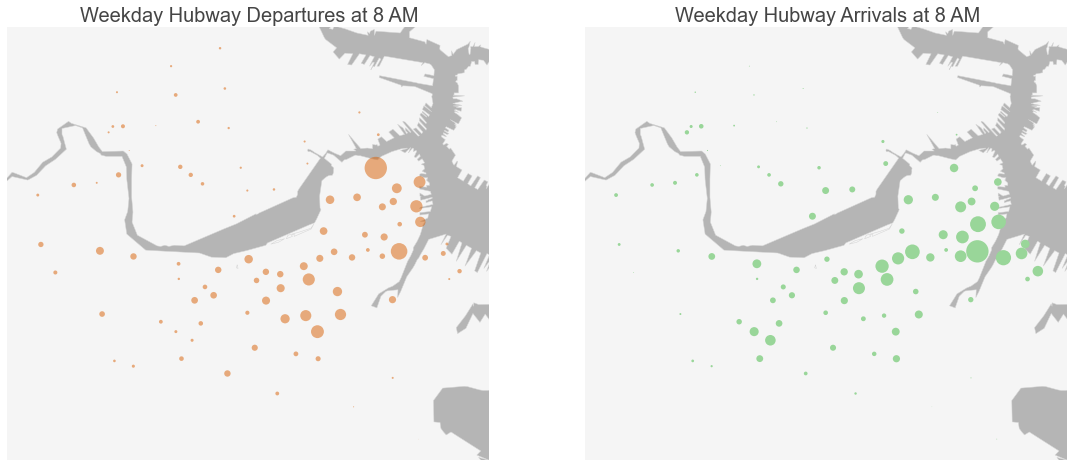

In [85]:
#create dataframe with trips on weekdays from may to september 2012
tripsfilt=  trips.loc[trips.st_month >= 5 ]
tripsfilt=  tripsfilt.loc[tripsfilt.end_month <10 ]
weekdaystations=  tripsfilt.loc[tripsfilt.st_weekday <5 ]
del tripsfilt

#call function to map stations
stationmap(weekdaystations, 8)

### 2.2.2 Emptiness and Fullness

The asymmetry in trips and dominance of certain stations results in stations being full or empty. The following plot illustrates the distribution of emptyness and fullness (as proportions of time empty/full) across the study period. It is evident that, on average across the system, stations are empty more often than they are full. Furthermore, the majority of stations are full or empty very little of time, while a handful are perpetually empty or full.

In [103]:
statusintervals['fullness']=statusintervals.latest_num_bikes/statusintervals.latest_capacity
FullStatus=statusintervals
FullStatus['EmptyFull']=pd.np.where(FullStatus.fullness==1,'Full',np.where(FullStatus.fullness==0,'Empty','Partial'))
StatusCounts=pd.DataFrame(FullStatus['station_id'].value_counts()).reset_index()
StatusCounts.columns=['station_id','StatusCounts']

# Groupby to find out counts of how often each station is empty, full, and partial
EmptyFullFreq=FullStatus.groupby(['station_id','EmptyFull']).count().reset_index()
EmptyFullFreq=pd.merge(left=EmptyFullFreq,right=StatusCounts,how='left',on='station_id')

#Eliminate 'partial' rows
EmptyFullFreq=EmptyFullFreq[EmptyFullFreq['EmptyFull']!='Partial']

#Create 'emptyfullfreq' column in DF
EmptyFullFreq['emptyfullfreq']=EmptyFullFreq.fullness/EmptyFullFreq.StatusCounts

#Drop unnecessary columns
EmptyFullFreq=EmptyFullFreq[['station_id','EmptyFull','emptyfullfreq']]

#Isolate fullness rows, sort, and prepare to plot
FullFreq=EmptyFullFreq[EmptyFullFreq['EmptyFull']=='Full']
FullFreq=FullFreq.sort('emptyfullfreq', ascending=False)
SortedStationsFull=FullFreq.station_id.tolist()
SortedStationsFull=[str(x) for x in SortedStationsFull]

#Isolate emptiness rows, sort, and prepare to plot
EmptyFreq=EmptyFullFreq[EmptyFullFreq['EmptyFull']=='Empty']
EmptyFreq=EmptyFreq.sort('emptyfullfreq', ascending=False)
SortedStationsEmpty=EmptyFreq.station_id.tolist()
SortedStationsEmpty=[str(x) for x in SortedStationsEmpty]

#Plot emptiness frequency
plt.figure(figsize=(30,12))
plt.xticks(visible=False)
plt.bar(np.arange(1,len(EmptyFreq)+1),EmptyFreq.emptyfullfreq,align='center',color=dark_colors[1], alpha=1)
plt.xticks(visible=False)
plt.tick_params(axis='both', which='major', labelsize=25);

#Plot fullness frequency
plt.bar(np.arange(1,len(FullFreq)+1),FullFreq.emptyfullfreq,align='center',color=dark_colors[0], alpha=1)
plt.xticks(visible=False)
plt.xlabel('Stations', size=30)
plt.ylabel('Proportion of time empty/full' ,size=30)
plt.title('Proportion of time empty/full, by station',size=35)
plt.legend(['Empty', 'Full'], fontsize=25);


MemoryError: 

In [82]:
###Prepare dataset
statusintervals['fullness']=statusintervals.latest_num_bikes/statusintervals.latest_capacity
FullStatus=statusintervals[(statusintervals.latest_capacity>0)&(statusintervals.weekday<5)]
FullStatus['EmptyFull']=pd.np.where(FullStatus.fullness==1,'Full',np.where(FullStatus.fullness==0,'Empty','Partial'))

#Eliminate 'partial' rows
FullStatus2=FullStatus[FullStatus['EmptyFull']!='Partial']

#Create full/empty frequency DFs for AM and PM peaks
PM_PeakFullStatus=FullStatus2[(FullStatus2['hour']>=16) & (FullStatus2['hour']<=18)]
AM_PeakFullStatus=FullStatus2[(FullStatus2['hour']>=8) & (FullStatus2['hour']<=9)]

PM_StatusCounts=FullStatus[(FullStatus['hour']>=16) & (FullStatus['hour']<=18)]
AM_StatusCounts=FullStatus[(FullStatus['hour']>=8) & (FullStatus['hour']<=9)]
PM_StatusCounts=pd.DataFrame(PM_StatusCounts['station_id'].value_counts()).reset_index()
AM_StatusCounts=pd.DataFrame(AM_StatusCounts['station_id'].value_counts()).reset_index()
AM_StatusCounts.columns=['station_id','StatusCounts']
PM_StatusCounts.columns=['station_id','StatusCounts']

# Groupby to find out counts of how often each station is empty, full, during peaks
AM_PeakFullStatus=AM_PeakFullStatus.groupby(['station_id','EmptyFull']).count().reset_index()
AM_PeakFullStatus=pd.merge(left=AM_PeakFullStatus,right=AM_StatusCounts,how='left',on='station_id')
PM_PeakFullStatus=PM_PeakFullStatus.groupby(['station_id','EmptyFull']).count().reset_index()
PM_PeakFullStatus=pd.merge(left=PM_PeakFullStatus,right=PM_StatusCounts,how='left',on='station_id')

#Create 'emptyfullfreq' column in DFs
AM_PeakFullStatus['emptyfullfreq']=AM_PeakFullStatus.fullness/AM_PeakFullStatus.StatusCounts
PM_PeakFullStatus['emptyfullfreq']=PM_PeakFullStatus.fullness/PM_PeakFullStatus.StatusCounts

#Drop unnecessary columns
AM_PeakFullStatus=AM_PeakFullStatus[['station_id','EmptyFull','emptyfullfreq']]
PM_PeakFullStatus=PM_PeakFullStatus[['station_id','EmptyFull','emptyfullfreq']]

MemoryError: 

In [83]:
def PeakMap(dataset):
    
    #Create lat/long lists for all stations and for top ten biggest problem stations
    latlist = dataset.lat.tolist()
    lonlist = dataset.lng.tolist()
    latlist10 = latlist[0:9]
    lonlist10 = lonlist[0:9]
    
    #identify order of items in dataset
    order=[int(item) for item in dataset.index]
    order10=order[0:9]
    problem=[float(item)*100 for item in dataset.emptyfullfreq]
    
    #prepare basemap
    m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
    m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)

    # compute the native map projection coordinates for cities 
    x,y = m(lonlist,latlist)
    x10,y10 = m(lonlist10,latlist10)
    
    #scatter scaled circles at the city locations 
    m.scatter( x, y, marker='o', c=problem, cmap='seismic', s=150, zorder = 2, )
    plt.colorbar()
    
    return plt.show()

Next, we explore the likelihood stations are empty or full during the morning commute (8-10 AM). As we might expect, stations located in major employment centers such as Back Bay, Downtown, MIT, Seaport, and Longwood Medical are full most often. Conversely, stations located in more residential areas like the South end, North End, Central Square, and Charlestown are empty most often.

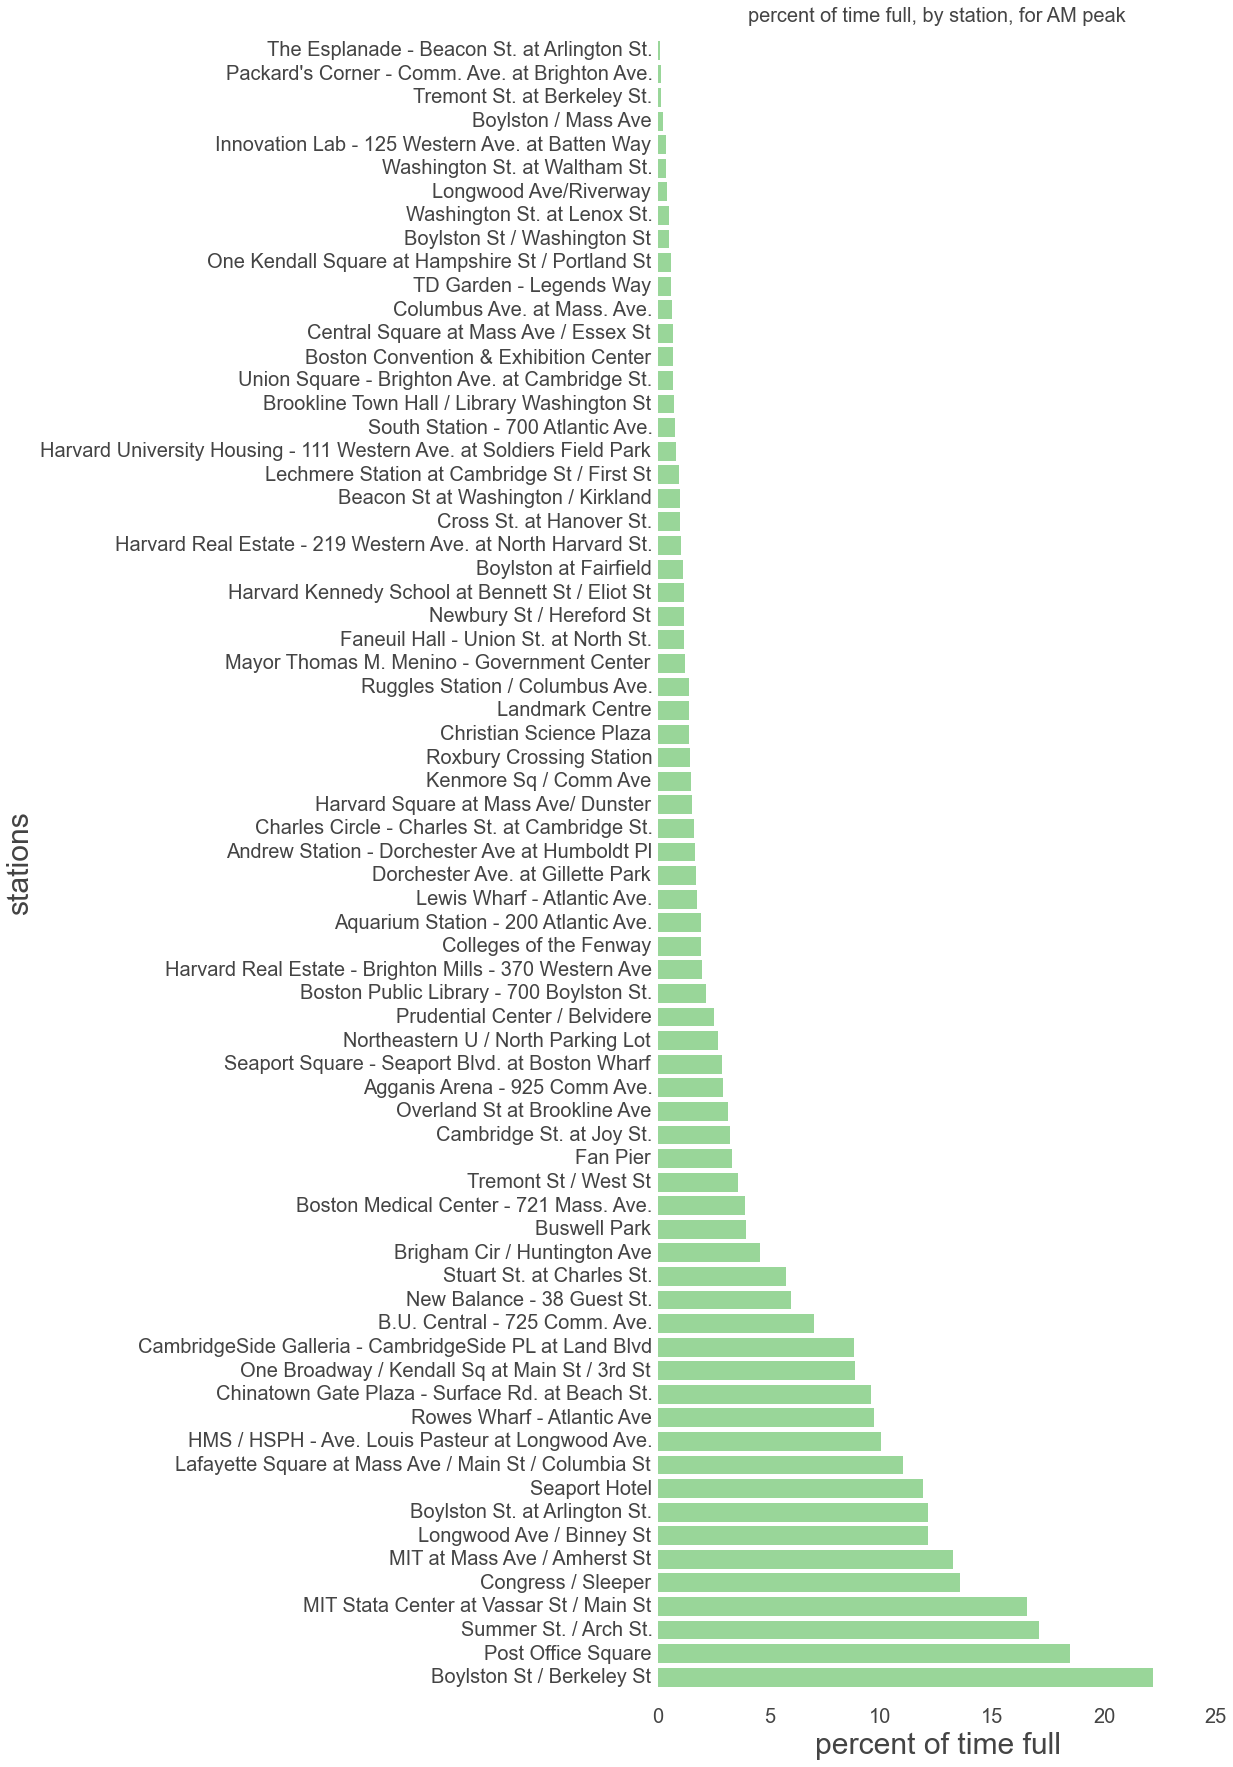

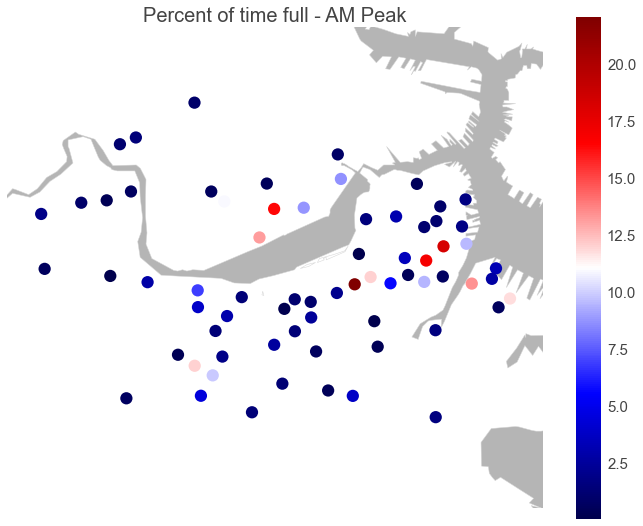

In [81]:
#Isolate fullness rows, sort, and prepare to plot
AM_FullFreq=AM_PeakFullStatus[AM_PeakFullStatus['EmptyFull']=='Full']
AM_FullFreq=AM_FullFreq.sort('emptyfullfreq', ascending=False)
AM_SortedStationsFull=AM_FullFreq.station_id.tolist()
AM_SortedStationsFull=[str(x) for x in AM_SortedStationsFull]

#List of worst stations
AM_FullID=[int(x) for x in AM_SortedStationsFull]
AM_Full_top=pd.DataFrame(AM_FullID)
AM_Full_top.columns=['id']
AM_Full_top=pd.merge(AM_Full_top,stations,on='id',how='left')

#Plot fullness frequency
plt.figure(figsize=(10,30))
plt.barh(np.arange(1,len(AM_FullFreq)+1),[float(item)*100 for item in AM_FullFreq.emptyfullfreq],align='center',color=dark_colors[0])
plt.yticks(range(1,len(AM_FullFreq.emptyfullfreq)+1),AM_Full_top.station,size='small')
plt.ylabel('stations',size=30)
plt.xlabel('percent of time full',size=30)
plt.title('percent of time full, by station, for AM peak')
plt.tick_params(axis='both',which='major',labelsize=20)
plt.ylim([0,len(AM_FullFreq.emptyfullfreq)+1])
plt.show()

#Map of worst stations
AM_FullFreq.columns=['id','EmptyFull','emptyfullfreq']
AM_Full_top=pd.merge(AM_Full_top,AM_FullFreq,on='id',how='left')
plt.title('Percent of time full - AM Peak', fontsize=20)
PeakMap(AM_Full_top) 



####AM-Peak Full

Stations near tufts medical center and MIT tend to fill up during weekday morning commutes. This is unsurprising, as these areas are prime workday destinations. 

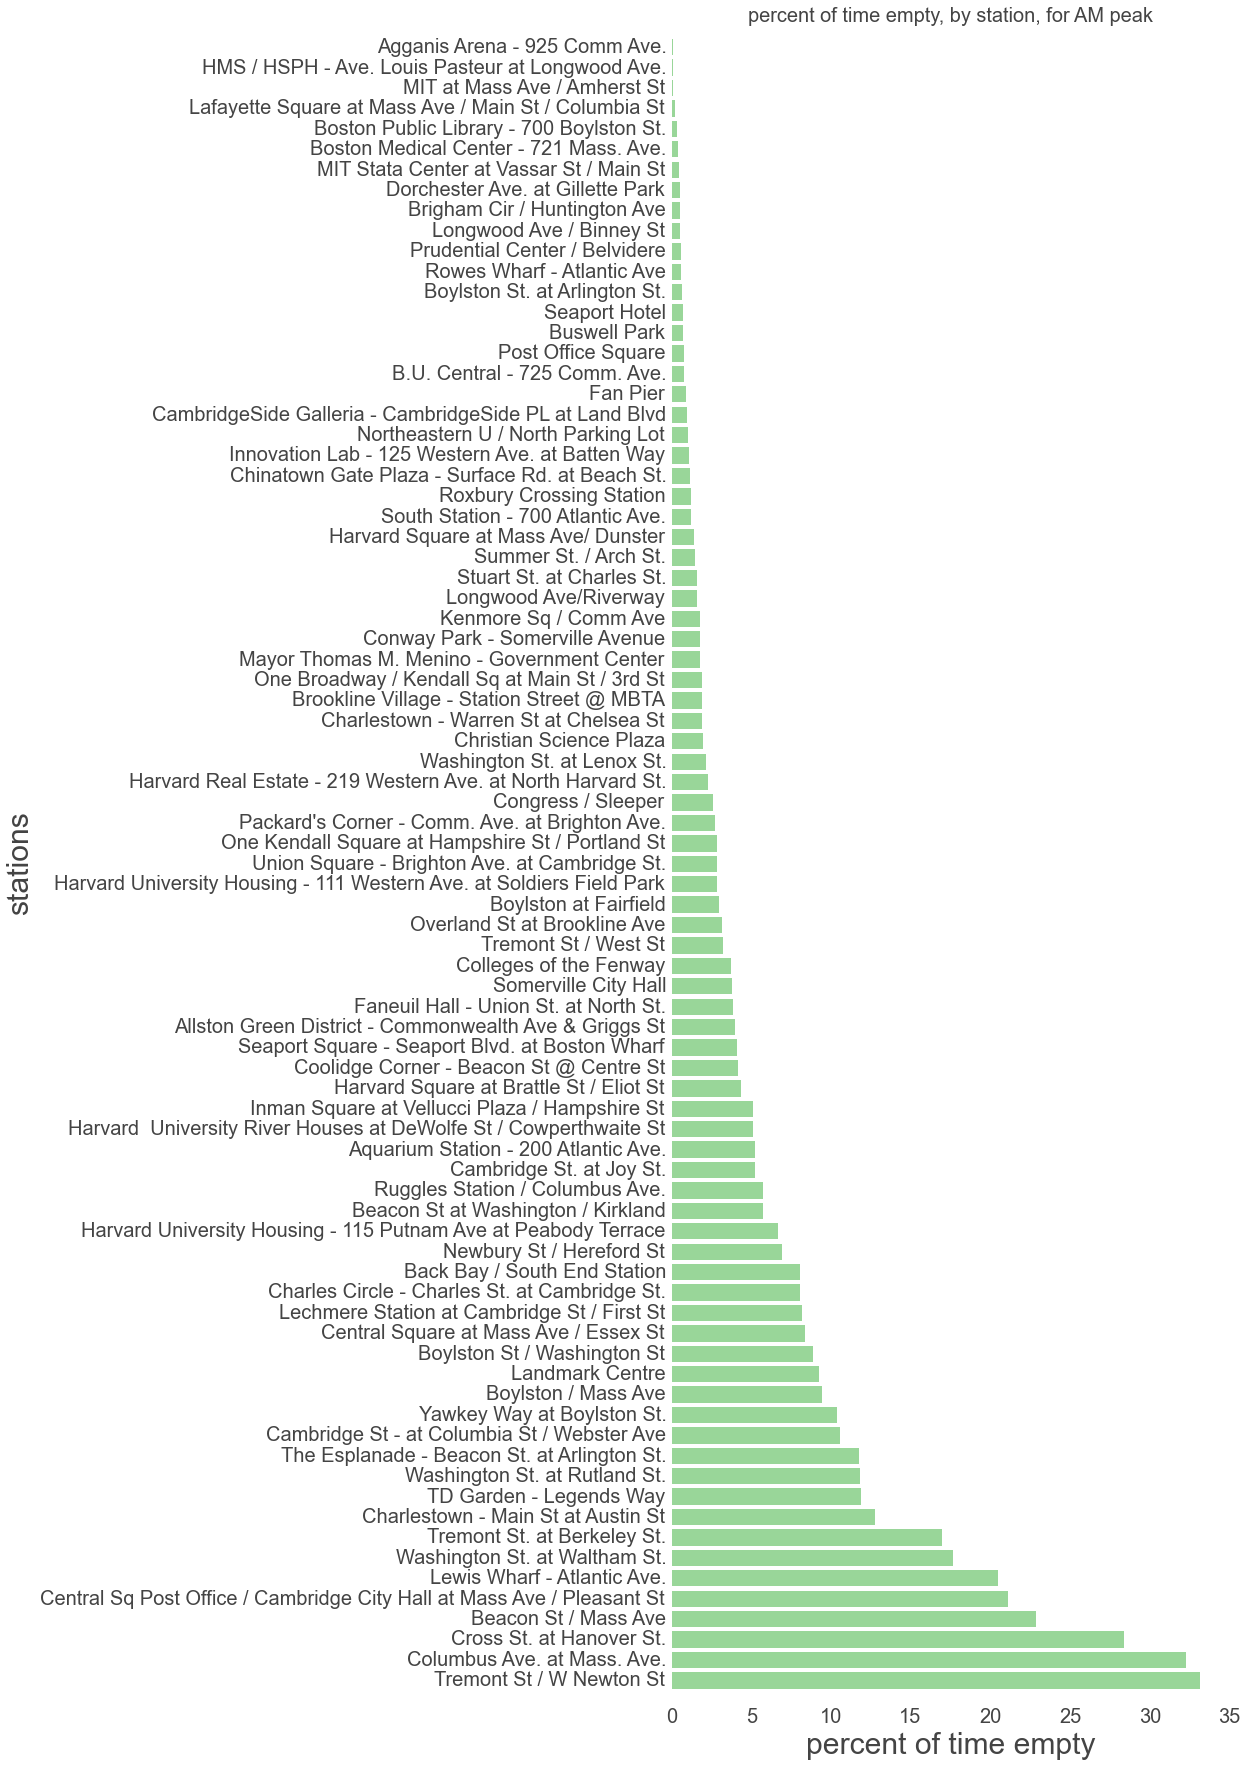

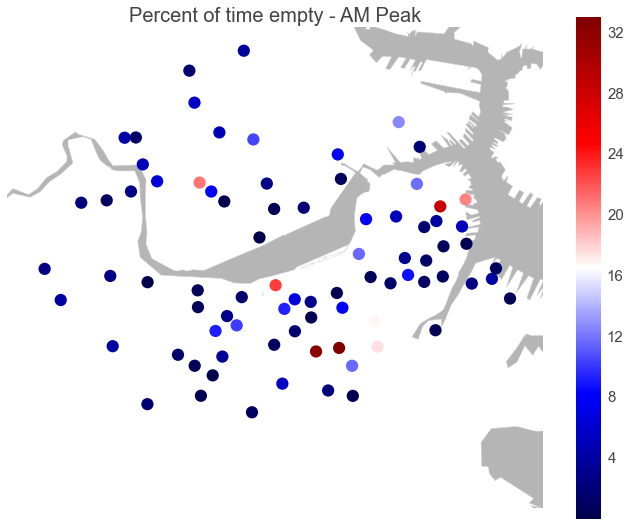

In [82]:
#Isolate fullness rows, sort, and prepare to plot
AM_EmptyFreq=AM_PeakFullStatus[AM_PeakFullStatus['EmptyFull']=='Empty']
AM_EmptyFreq=AM_EmptyFreq.sort('emptyfullfreq', ascending=False)
AM_SortedStationsEmpty=AM_EmptyFreq.station_id.tolist()
AM_SortedStationsEmpty=[str(x) for x in AM_SortedStationsEmpty]

#List of worst stations
AM_EmptyID=[int(x) for x in AM_SortedStationsEmpty]
AM_Empty_top=pd.DataFrame(AM_EmptyID)
AM_Empty_top.columns=['id']
AM_Empty_top=pd.merge(AM_Empty_top,stations,on='id',how='left')

#Plot fullness frequency
plt.figure(figsize=(10,30))
plt.barh(np.arange(1,len(AM_EmptyFreq)+1),[float(item)*100 for item in AM_EmptyFreq.emptyfullfreq],align='center',color=dark_colors[0])
plt.yticks(range(1,len(AM_EmptyFreq.emptyfullfreq)+1),AM_Empty_top.station,size='small')
plt.ylabel('stations',size=30)
plt.xlabel('percent of time empty',size=30)
plt.title('percent of time empty, by station, for AM peak')
plt.tick_params(axis='both',which='major',labelsize=20)
plt.ylim([0,len(AM_EmptyFreq.emptyfullfreq)+1])
plt.show()

#Map of worst stations
AM_EmptyFreq.columns=['id','EmptyFull','emptyfullfreq']
AM_Empty_top=pd.merge(AM_Empty_top,AM_EmptyFreq,on='id',how='left')
plt.title('Percent of time empty - AM Peak', fontsize=20)
PeakMap(AM_Empty_top)


####AM-Peak Empty

Stations in Back Bay and the North End tend to empty during weekday morning commutes. This is unsurprising, as these areas are Boston’s primary residential areas. 

### PM-Peak Analysis
Next, we explore the likelihood stations are empty or full during the evening commute (4-6 PM). The trends here appear to mirror that of the AM peak, with stations located in more residential are most often full, while those located in employment centers are most often empty.

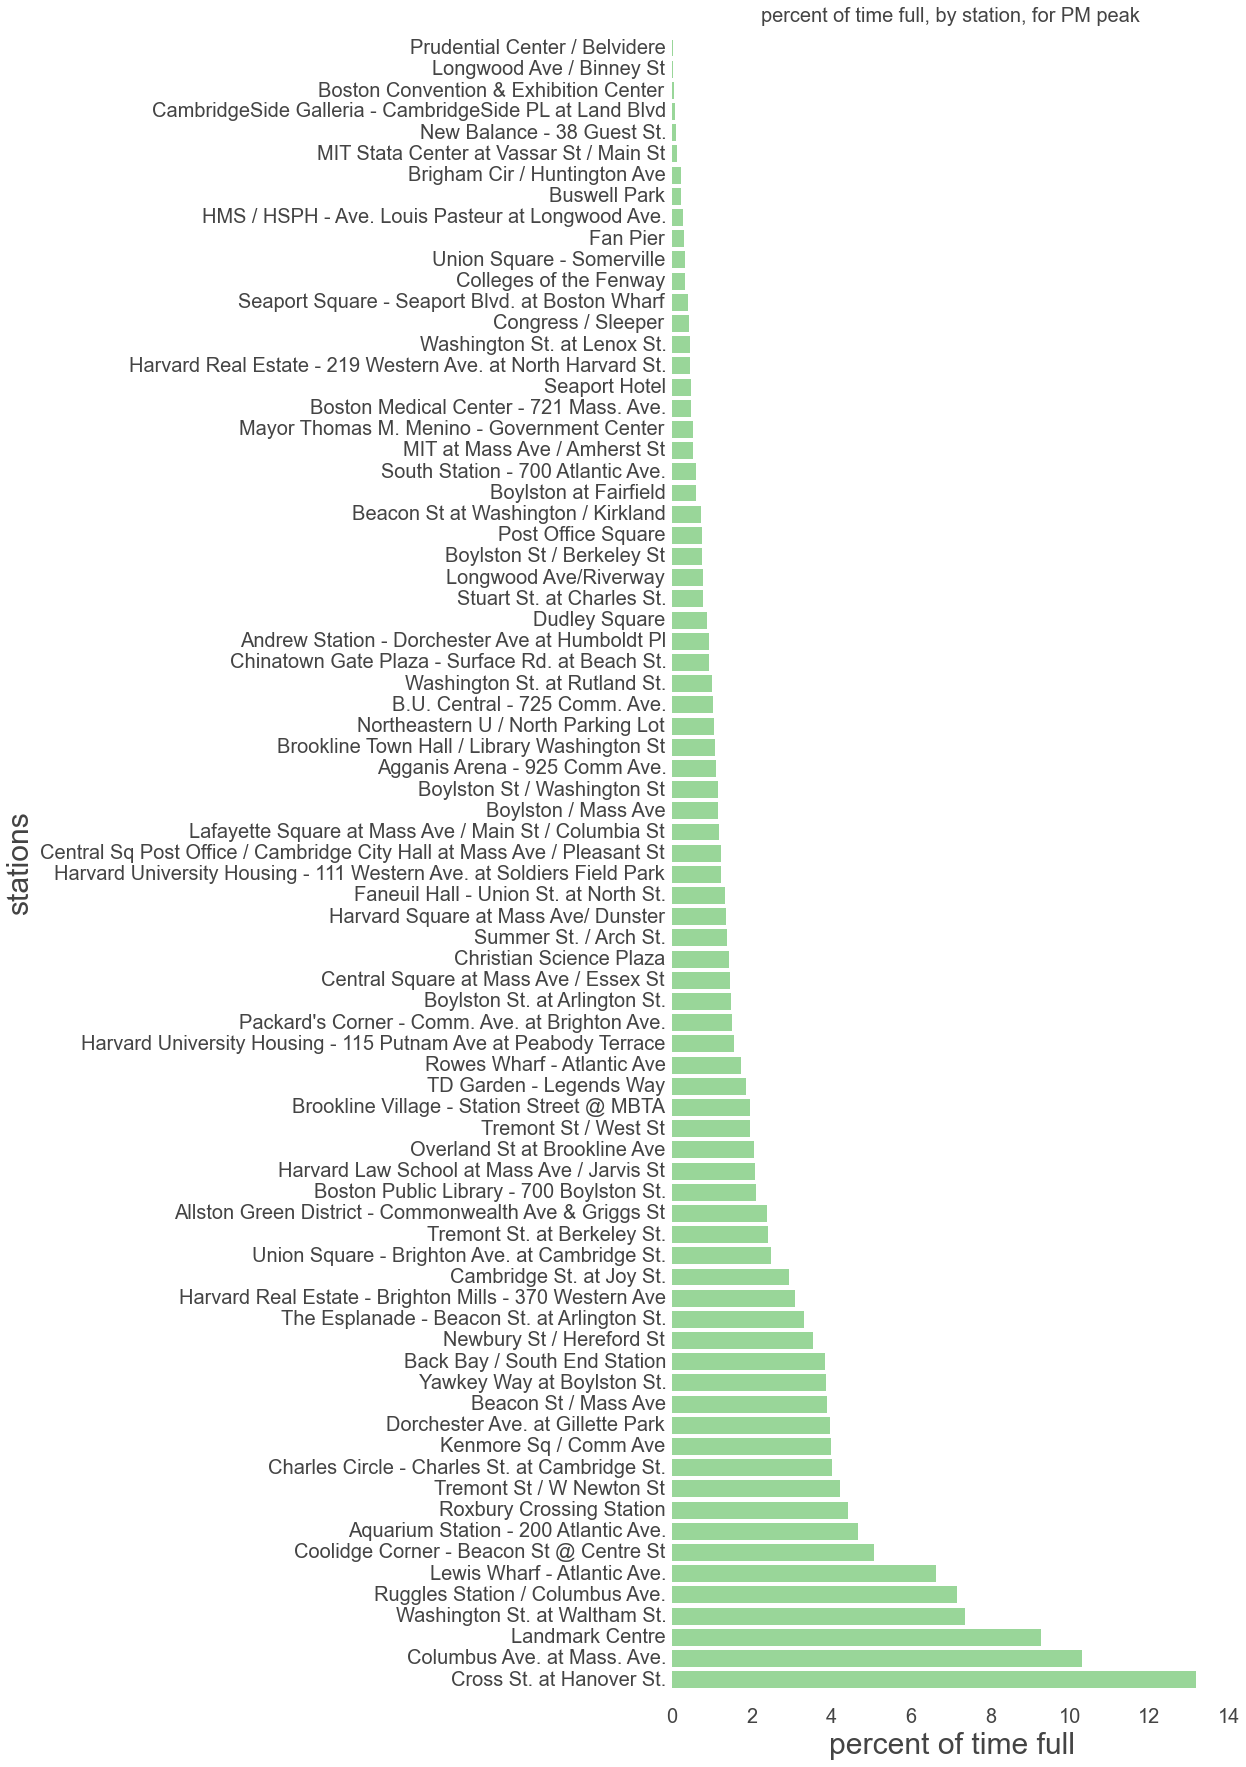

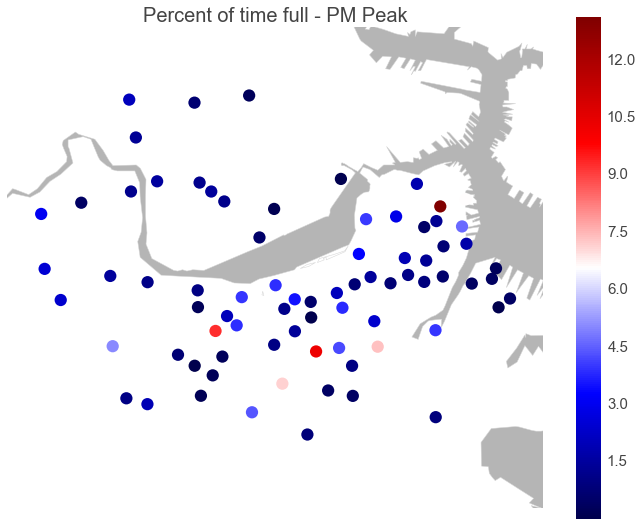

In [83]:
#Isolate fullness rows, sort, and prepare to plot
PM_FullFreq=PM_PeakFullStatus[PM_PeakFullStatus['EmptyFull']=='Full']
PM_FullFreq=PM_FullFreq.sort('emptyfullfreq', ascending=False)
PM_SortedStationsFull=PM_FullFreq.station_id.tolist()
PM_SortedStationsFull=[str(x) for x in PM_SortedStationsFull]

#List of worst stations
PM_FullID=[int(x) for x in PM_SortedStationsFull]
PM_Full_top=pd.DataFrame(PM_FullID)
PM_Full_top.columns=['id']
PM_Full_top=pd.merge(PM_Full_top,stations,on='id',how='left')

#Plot fullness frequency
plt.figure(figsize=(10,30))
plt.barh(np.arange(1,len(PM_FullFreq)+1),[float(item)*100 for item in PM_FullFreq.emptyfullfreq],align='center',color=dark_colors[0])
plt.yticks(range(1,len(PM_FullFreq.emptyfullfreq)+1),PM_Full_top.station,size='small')
plt.ylabel('stations',size=30)
plt.xlabel('percent of time full',size=30)
plt.title('percent of time full, by station, for PM peak')
plt.tick_params(axis='both',which='major',labelsize=20)
plt.ylim([0,len(PM_FullFreq.emptyfullfreq)+1])
plt.show()

#Map of worst stations
PM_FullFreq.columns=['id','EmptyFull','emptyfullfreq']
PM_Full_top=pd.merge(PM_Full_top,PM_FullFreq,on='id',how='left')
plt.title('Percent of time full - PM Peak', fontsize=20)
PeakMap(PM_Full_top)

####PM-Peak Full

Stations in Back Bay and the North End tend to empty during weekday evening commutes. This is unsurprising, as these areas are Boston’s primary residential areas. 

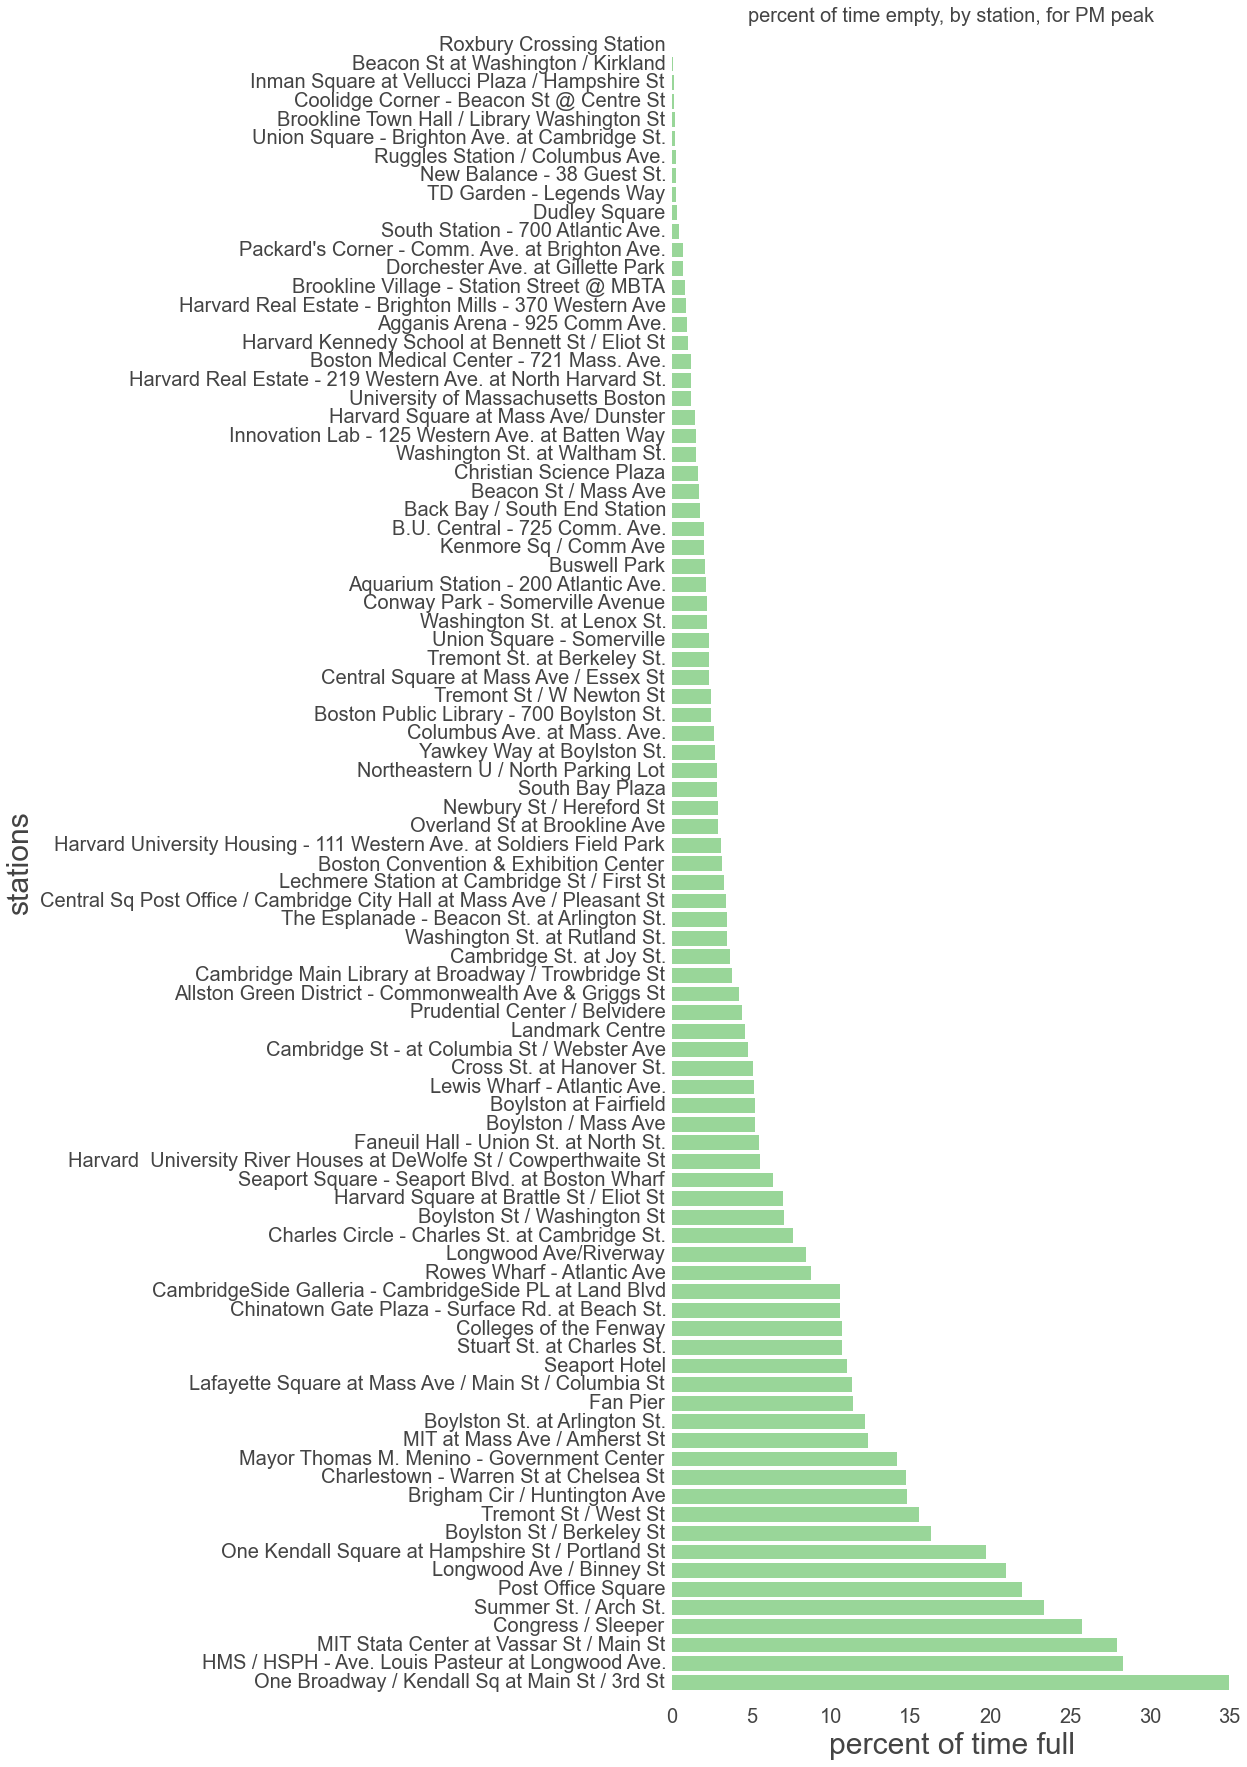

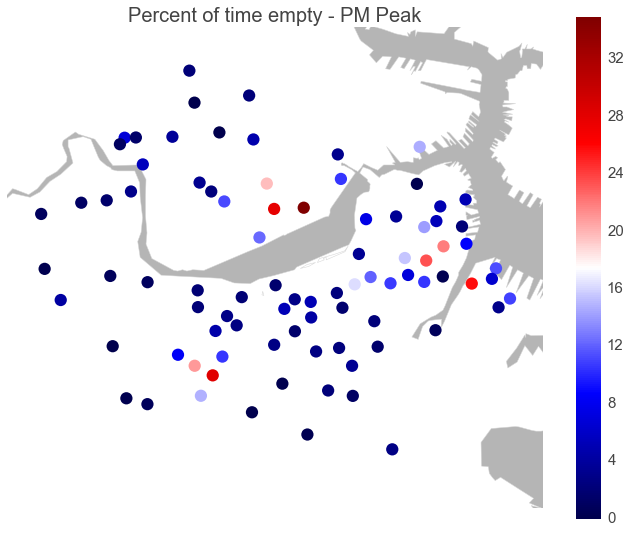

In [84]:
#Isolate fullness rows, sort, and prepare to plot
PM_EmptyFreq=PM_PeakFullStatus[PM_PeakFullStatus['EmptyFull']=='Empty']
PM_EmptyFreq=PM_EmptyFreq.sort('emptyfullfreq', ascending=False)
PM_SortedStationsEmpty=PM_EmptyFreq.station_id.tolist()
PM_SortedStationsEmpty=[str(x) for x in PM_SortedStationsEmpty]

#List of worst stations
PM_EmptyID=[int(x) for x in PM_SortedStationsEmpty]
PM_Empty_top=pd.DataFrame(PM_EmptyID)
PM_Empty_top.columns=['id']
PM_Empty_top=pd.merge(PM_Empty_top,stations,on='id',how='left')

#Plot fullness frequency
plt.figure(figsize=(10,30))
plt.barh(np.arange(1,len(PM_EmptyFreq)+1),[float(item)*100 for item in PM_EmptyFreq.emptyfullfreq],align='center',color=dark_colors[0])
plt.yticks(range(1,len(PM_EmptyFreq.emptyfullfreq)+1),PM_Empty_top.station,size='small')
plt.ylabel('stations',size=30)
plt.xlabel('percent of time full',size=30)
plt.title('percent of time empty, by station, for PM peak')
plt.tick_params(axis='both',which='major',labelsize=20)
plt.ylim([0,len(PM_EmptyFreq.emptyfullfreq)+1])
plt.show()

#Map of worst stations
PM_EmptyFreq.columns=['id','EmptyFull','emptyfullfreq']
PM_Empty_top=pd.merge(PM_Empty_top,PM_EmptyFreq,on='id',how='left')
plt.title('Percent of time empty - PM Peak', fontsize=20)
PeakMap(PM_Empty_top)

#### PM Empty

Stations near tufts medical center and MIT tend to empty up during weekday evening commutes. This is unsurprising, as these areas are prime workday destinations.

Overall, the commuting patterns we observed by plotting station trends geographically confirmed our suspicions. These plots suggested that the likelihood of a station being empty or full during either the morning or evening commute depends in large part on its proximity to residential and commercial areas. 

### 2.2.3 Clustering stations fullness profiles
In order to understand the causes and characteristics of station fullness and emptiness, we examine the usage patterns of different stations. We expect certain stations are used in similar ways by users based on their location and the type of neighborhood they serve. For example, stations located in the urban core are likely to fill-up as the morning commuters converge down-town to work and to empty in the evening as they return home. While each station is unique, it is useful to consider such similarity in usage patterns to understand the dynamics of network imbalances.

The evolution of station fullness over time of day is a useful metric to extract such similarities. Fullness profile is obtained by averaging the ratio of number bicycles over station capacity for each station over all days in the 2012 season. Fullness ratio for a station $i$ at interval $t$ is computed as follows :
$ f_{i,t}= \frac{1}{n}\sum_{i=1}^{n} \frac{bikes_{i,t}}{capacity_{i,t}}$
where $n$ represents the number of week days in the 2012 season.

From these, stations are described by 288 features representing fullness for each 5-minute intervals of a typical weekday.
We then compute a linear transformation of these features from SVD to reduce the dimensionality of this profile. 
From the resulting transformation we perform a simple K-Means cluster analysis to group together stations with similar fullness/emptiness profiles. 


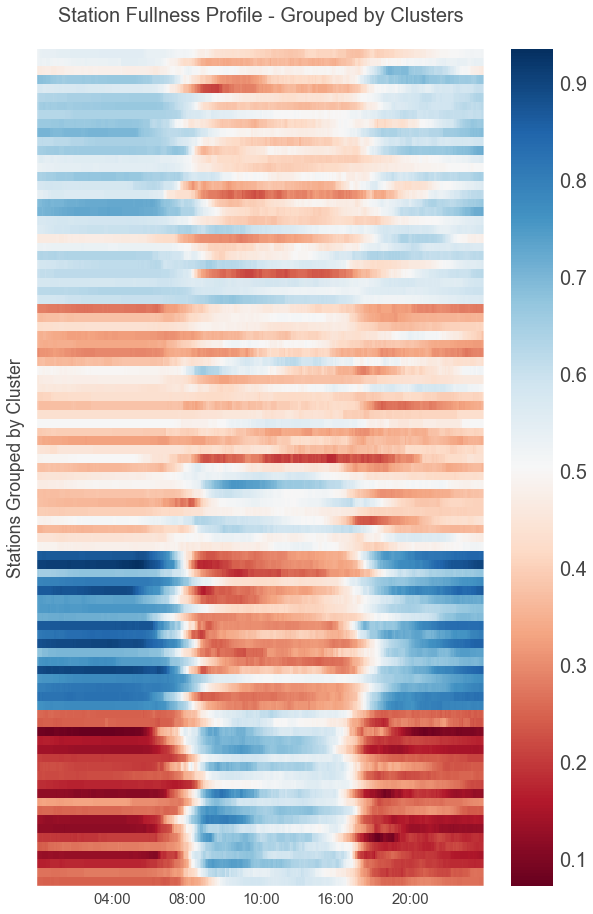

In [19]:
# Compute the fullness ratio as the number of bikes over the capacity for each interval
statusintervals['fullness_ratio']=statusintervals.latest_num_bikes/statusintervals.latest_capacity

# Differentiate Between weekdays and week-end days
statusintervals['week']=statusintervals.weekday < 5

# Group by station and interval of the day for week days and pivot into a matrix
fullness = statusintervals.loc[statusintervals.week == True].groupby(['station_id','minute'])['fullness_ratio'].mean()
fullness = fullness.reset_index().pivot(index='station_id', columns='minute', values='fullness_ratio')

#Perform SVD to extract principal components
fullness_trans = (fullness - fullness.mean(axis=0))
svd = sklearn.decomposition.TruncatedSVD(n_components=6, random_state=38)
fullness_trans = svd.fit_transform(fullness_trans)

#Use Principal Components to CLuster the Fullness Profiles
km = sklearn.cluster.KMeans(n_clusters=4, init='k-means++', n_init=20, max_iter=300)
fullness['cluster_id'] = km.fit_predict(fullness_trans[:,0:9])
fullness_sorted = fullness.sort(['cluster_id'])

#Plot Image of All Fullness profiles ordered by clusterid clustering
plt.figure(figsize=(10,15))
imgplot = plt.imshow(fullness_sorted.ix[:,0:-1],aspect='auto',interpolation='none')
imgplot.set_cmap('RdBu')
plt.yticks([0],[''])
plt.ylabel('Stations Grouped by Cluster')
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20) 
plt.xticks([48,96,144,192,240], ['04:00', '08:00', '10:00','16:00','20:00'])
plt.title('Station Fullness Profile - Grouped by Clusters \n');

In [25]:
def ClusterMap(weekday):
    
    #Create lat/long lists for all stations
    clusterlist=fullness.reset_index()[['station_id','cluster_id']]
    clusterlist1=clusterlist[clusterlist['cluster_id']==0]
    clusterlist2=clusterlist[clusterlist['cluster_id']==1]
    clusterlist3=clusterlist[clusterlist['cluster_id']==2]
    clusterlist4=clusterlist[clusterlist['cluster_id']==3]

    clusterstations1=stations[stations['id'].isin(clusterlist1['station_id'])]
    clusterstations2=stations[stations['id'].isin(clusterlist2['station_id'])]
    clusterstations3=stations[stations['id'].isin(clusterlist3['station_id'])]
    clusterstations4=stations[stations['id'].isin(clusterlist4['station_id'])]

    latlist1 =clusterstations1.lat.tolist()
    lonlist1 =clusterstations1.lng.tolist()
    latlist2 =clusterstations2.lat.tolist()
    lonlist2 =clusterstations2.lng.tolist()
    latlist3 =clusterstations3.lat.tolist()
    lonlist3 =clusterstations3.lng.tolist()
    latlist4 =clusterstations4.lat.tolist()
    lonlist4 =clusterstations4.lng.tolist()
    
    #prepare basemap
    m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
    m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)

    # compute the native map projection coordinates for cities 
    x1,y1 = m(lonlist1,latlist1)
    x2,y2 = m(lonlist2,latlist2)
    x3,y3 = m(lonlist3,latlist3)
    x4,y4 = m(lonlist4,latlist4)

    #scale stations to account for relative frequency of peak times full and empty
#     clusters= clusterlist.cluster_id
#     clusters= [str(item/255) for item in fullness.cluster_id]
    

 #scatter scaled circles at the city locations 
    cls1=m.scatter( x1, y1, marker='o', c=dark_colors[0], edgecolors='b',alpha=0.5, s=300, zorder = 2, )
    cls2=m.scatter( x2, y2, marker='o', c=dark_colors[1], edgecolors='b',alpha=0.5, s=300, zorder = 2, )  
    cls3=m.scatter( x3, y3, marker='o', c=dark_colors[2], edgecolors='b',alpha=0.5, s=300, zorder = 2, )  
    cls4=m.scatter( x4, y4, marker='o', c=dark_colors[3], edgecolors='b',alpha=0.5, s=300, zorder = 2, )  
    plt.title('Station Clusters: stations with similar peak commute patterns', fontsize=20)
    plt.legend((cls2,cls3,cls1,cls4),('non-commuter 1','outbound commuter','non-commuter cluster 2','inbound commuter'),bbox_to_anchor=(1, 1), loc=2)
    
    return plt.show()

Mapping stations and then identifying them by their cluster membership reveals how geography helps to inform usage patterns. Blue circles signify the stations that tend to be relatively full during midday and relatively empty during other hours of the day. Stations in this cluster lie mostly in downtown Boston and near Kendall and Central squares in Cambridge. They may represent destination stations for people using Hubway to commute to work or school each morning. For stations identified by tan circles, the trend is the opposite: these stations tend to be emptier during midday and fuller during early morning and late evening. They may represent departure stations for commuters leaving for work or school in the morning (or destination stations for commuters arriving home at night). Stations identified by green and gray circles have a less obvious pattern; these stations tend to be somewhere between moderately full and moderately empty throughout the day. They may simply enjoy lighter use than the first two clusters. 

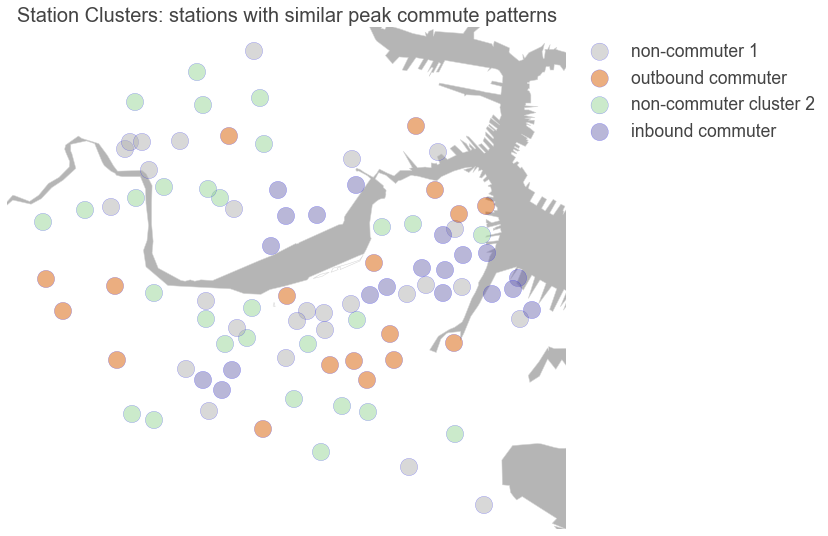

In [26]:
BestWorstweekdaystations=  stations['id']
ClusterMap(BestWorstweekdaystations)

# 3 PREDICTION

<a id = '3'></a>
-----

In this section, we explored using classification, bayesian, and regression techniques models predict the occurances of empty or full Hubway stations.

## 3.1 Prediction Dataframe
<a id = '3.1'></a>
-----

Here we prepare key predictive variables to be used by each model, including:
* historical average arrivals and departures by station, weekday, and interval
* lagged station status variables for various prediction windows
* emptyness/fullness ratio and dummy variables
* baseball and basketball dummy variables set to 1 for intervals falling an hour before (for arrivals) and an hour after (for departures) Red Sox and Celtics home games, respectively.

Lastly, we use a 2/3:1/3 training:test split to produce dataframes to train and test our models.


###3.1.1 Prediction Variables

In [27]:
###--- Weather---###
reg_df= pd.merge(statusintervals, weather[['daydate', 'hour', 'precip', 'temp']],
                 how='left', on=['daydate', 'hour'])


###--- Historical Averages ---###
# Averages for the same stationid, weekday, time of day (5 min interval)
hist_avg = reg_df.groupby(['station_id','weekday','minute'])[['bike_arrivals', 'bike_departures']].mean()
hist_avg.columns = ['hist_arr', 'hist_dep']
reg_df=reg_df.merge(hist_avg, how='left', left_on=['station_id','weekday','minute'], right_index=True)


###--- "Real-time" Previous Station Status ---###
# define the prediction windows and lags to be considered ##
pred_windows = np.array([10,30])
nbr_prev = 3
lags = range(5, nbr_prev*5+max(pred_windows)+1, 5)

# Create Lag Columns from 5 minutes to X (e.g. 30) minutes (as determined from largest window)
for lag in lags:
    reg_df['arr_lag'+str(lag)]=reg_df.groupby(['station_id'])['bike_arrivals'].shift(lag/5)
    reg_df['dep_lag'+str(lag)]=reg_df.groupby(['station_id'])['bike_departures'].shift(lag/5)    

# Compute "Real-Time" information from recent past    
for window in pred_windows:
    i= window/5-1
    # Take the mean of nbr_prev(e.g. 3 previous periods) for each prediction window 
    reg_df['avg_arr_'+str(window)]= reg_df[['arr_lag'+str(lag) for lag in lags[i:i+nbr_prev]]].mean(axis=1)
    reg_df['avg_dep_'+str(window)]= reg_df[['dep_lag'+str(lag) for lag in lags[i:i+nbr_prev]]].mean(axis=1)
    
    #compute the lags for each prediction window
    reg_df['lagmins'+str(window)] = reg_df.groupby(['station_id'])['minute'].shift(window/5)
    reg_df['lagbikes'+str(window)]=reg_df.groupby(['station_id'])['latest_num_bikes'].shift(window/5)
    reg_df['lagcap'+str(window)]=reg_df.groupby(['station_id'])['latest_capacity'].shift(window/5)
    reg_df['isempty'+str(window)]=(reg_df['lagbikes'+str(window)]==0)*1.0
    reg_df['isfull'+str(window)]=(reg_df['lagbikes'+str(window)]==reg_df['lagcap'+str(window)])*1.0
    
    #Sum number of departures and arrivals in last "window" period
    reg_df['net_arr'+str(window)] = reg_df.loc[:,'arr_lag'+str(5):'arr_lag'+str(window)].sum(axis=1) - \
                                    reg_df.loc[:,'dep_lag'+str(5):'dep_lag'+str(window)].sum(axis=1)
    
    
reg_df.drop(['arr_lag'+str(lag) for lag in lags], axis=1, inplace=True)
reg_df.drop(['dep_lag'+str(lag) for lag in lags], axis=1, inplace=True)



###--- Label Variable ---###
reg_df['isfull']= reg_df['latest_capacity'] == reg_df['latest_num_bikes']
reg_df['isempty']= reg_df['latest_num_bikes'] == 0
reg_df['fullness']= reg_df['latest_num_bikes']/reg_df['latest_capacity']
reg_df['fullness10']= reg_df['lagbikes10']/reg_df['lagcap10']
reg_df['fullness30']= reg_df['lagbikes30']/reg_df['lagcap30']
        
###--- Baseball Events ---###
mlb_df= pd.merge(statusintervals, MLB[['daydate', 'start_time', 'end_time']], how='left', on='daydate')

#compute difference between game start and end times and the given interval
mlb_df['st_diff']=mlb_df['start_time']-mlb_df['interv']
mlb_df['st_hrdiff']=mlb_df.st_diff.apply(lambda x: x / np.timedelta64(1, 'h'))
mlb_df['end_diff']=mlb_df['interv']-mlb_df['end_time']
mlb_df['end_hrdiff']=mlb_df.end_diff.apply(lambda x: x / np.timedelta64(1, 'h'))

#create an 'MLBarr' dummy variable and set to 1 if the interval is within an hour before the start time and the station is near fenway
#create an 'MLBdep' dummy variable and set to 1 if the interval is within an hour after the end time and the station is near fenway
fenwaystations = [32,33,45,101]
mlb_df['MLBarr']=np.zeros(len(mlb_df))
mlb_df['MLBdep']=np.zeros(len(mlb_df))
mlb_df['MLBarr'][(mlb_df.st_hrdiff<=1) & (mlb_df.st_hrdiff>=0) & (mlb_df.station_id.isin(fenwaystations))] = 1
mlb_df['MLBdep'][(mlb_df.end_hrdiff<=1) & (mlb_df.end_hrdiff>=0)  & (mlb_df.station_id.isin(fenwaystations))] = 1

#add dummy variables to regression dataframe and drop merged dataframe
reg_df=pd.merge(reg_df, mlb_df[['interv','station_id','MLBarr','MLBdep']],on=['interv','station_id'])
del mlb_df


###--- Basketball Events---###
nba_df= pd.merge(statusintervals, NBA[['daydate', 'start_time', 'end_time']], how='left', on='daydate')

#compute difference between game start and end times and the given interval
nba_df['st_diff']=nba_df['start_time']-nba_df['interv']
nba_df['st_hrdiff']=nba_df.st_diff.apply(lambda x: x / np.timedelta64(1, 'h'))
nba_df['end_diff']=nba_df['interv']-nba_df['end_time']
nba_df['end_hrdiff']=nba_df.end_diff.apply(lambda x: x / np.timedelta64(1, 'h'))

#create an 'NBAarr' dummy variable and set to 1 if the interval is within an hour before the start time and the station is near TD Garden
#create an 'NBAdep' dummy variable and set to 1 if the interval is within an hour after the end time and the station is near TD Garden
#id=114 is 'TD Garden - Causeway at Portal Park #1'
#id=111 is 'TD Garden - Causeway at Portal Park #2'
gardenstations = [111,114]
nba_df['NBAarr']=np.zeros(len(nba_df))
nba_df['NBAdep']=np.zeros(len(nba_df))
nba_df['NBAarr'][(nba_df.st_hrdiff<=1) & (nba_df.st_hrdiff>=0) & (nba_df.station_id.isin(fenwaystations))] = 1
nba_df['NBAdep'][(nba_df.end_hrdiff<=1) & (nba_df.end_hrdiff>=0)  & (nba_df.station_id.isin(fenwaystations))] = 1

#add dummy variables to regression dataframe drop merged dataframe
reg_df=pd.merge(reg_df, nba_df[['interv','station_id','NBAarr','NBAdep']],on=['interv','station_id'])
del nba_df

# Exclude edge cases on first day
reg_df= reg_df.loc[(reg_df.interv > datetime.datetime(2012,5,1,1))]

# Display Head of reg_df 
pd.set_option('max_columns', 100)
reg_df.head()


index              interv  station_id  bike_arrivals  bike_departures  \
780    780 2012-05-01 01:05:00           3              0                0   
781    781 2012-05-01 01:05:00           4              0                0   
782    782 2012-05-01 01:05:00           5              0                0   
783    783 2012-05-01 01:05:00           6              0                0   
784    784 2012-05-01 01:05:00           7              0                0   

     latest_num_bikes  latest_capacity  hour  minute  month     daydate  \
780                 4               15     1      65      5  2012-05-01   
781                15               15     1      65      5  2012-05-01   
782                10               14     1      65      5  2012-05-01   
783                11               15     1      65      5  2012-05-01   
784                 9               15     1      65      5  2012-05-01   

     weekday  fullness_ratio  week  precip  temp  hist_arr  hist_dep  \
780        1        0.266667  True       0  49.8  0.000000         0   
781        1        1.000000  True       0  49.8  0.136364         0   
782        1        0.714286  True       0  49.8  0.000000         0   
783        1        0.733333  True       0  49.8  0.000000         0   
784        1        0.600000  True       0  49.8  0.000000         0   

     avg_arr_10  avg_dep_10  lagmins10  lagbikes10  lagcap10  isempty10  \
780           0    0.000000         55           4        15          0   
781           0    0.000000         55          15        15          0   
782           0    0.333333         55          10        14          0   
783           0    0.000000         55          11        15          0   
784           0    0.000000         55           9        15          0   

     isfull10  net_arr10  avg_arr_30  avg_dep_30  lagmins30  lagbikes30  \
780         0          0    0.000000           0         35           4   
781         1          0    0.000000           0         35          15   
782         0          0    0.333333           0         35          11   
783         0          0    0.000000           0         35          11   
784         0          0    0.000000           0         35           9   

     lagcap30  isempty30  isfull30  net_arr30 isfull isempty  fullness  \
780        15          0         0          0  False   False  0.266667   
781        15          0         1          0   True   False  1.000000   
782        14          0         0          0  False   False  0.714286   
783        15          0         0          0  False   False  0.733333   
784        15          0         0          0  False   False  0.600000   

     fullness10  fullness30  MLBarr  MLBdep  NBAarr  NBAdep  
780    0.266667    0.266667       0       0       0       0  
781    1.000000    1.000000       0       0       0       0  
782    0.714286    0.785714       0       0       0       0  
783    0.733333    0.733333       0       0       0       0  
784    0.600000    0.600000       0       0       0       0

In [28]:
del statusintervals
del NBA
del MLB

### 3.1.2 Split Test/Train data

In [29]:
#split training and test data by 2/3, 1/3, respectively
df = pd.DataFrame(np.random.randn(len(reg_df), 1))
msk = np.random.rand(len(df)) < 0.6666
reg_df_train = reg_df[msk]
reg_df_test = reg_df[~msk]

# Drop original Dataframe for memory
del reg_df
print len(reg_df_train), len(reg_df_test)

2096539 1048091


## 3.2 Baseline
<a id = '3.2'></a>
-----

Our baseline prediction is analogous to the way in which riders use Hubway's real time station status info today: **we assume real-time station status will remain constant between when you look it up and when you arrive at your desired origin and destination stations**. In using a 10 minute horizon window for our empty predictions, we assume that riders look up whether or not there are bikes available at their origin station approximately 10 minutes before they arrive. Similarly, we use a 30 minute horizon window for our full predictions, under the assumption that riders look up bike and dock availability at their desired origin destination stations at the same time. Therefore, the implicit assumption is that their trip will take 20 minutes.

###3.2.1 Baseline Prediction

In [30]:
def baseline(intervaldf,wind):

    intervaldf['week']=(intervaldf['weekday'] >= 5)*1

    # Define Prediction Windows and Preallocate output variables (must be multiple of 5)
    windows = np.array(wind)

    # Preallocate recall Dataframe 
    stations=intervaldf.station_id.unique()
    hours = intervaldf.hour.unique()
    week = [0,1]
    recall = pd.DataFrame(columns = ['station_id', 'week', 'hour','P_empty','P_full'],
                            index = range(len(hours)*2*len(stations)),dtype=float)

    # Preassign Station, Hour and Weekday Values
    recall.station_id = np.repeat(np.transpose(stations), len(hours)*2)
    recall.week = np.repeat(np.transpose(np.tile(week,len(stations))),len(hours))
    recall.hour = np.tile(hours, len(stations)*len(week))
    recall = recall.set_index(['station_id','week','hour'])

    # Calculate nbr of Positives (Actually Full/Empty)
    recall['P_empty']= intervaldf[intervaldf['latest_num_bikes']==0]\
                                 .groupby(['station_id','week','hour'])['index'].count()
    recall['P_full']= intervaldf[intervaldf['latest_num_bikes']==intervaldf['latest_capacity']]\
                                .groupby(['station_id','week','hour'])['index'].count()
    
    # Loop through each Prediction Window
    for window in windows:
        status=intervaldf
        status = status[((status['minute']- status['lagmins'+str(window)])==window*1.0)
                        | ((status['minute']- status['lagmins'+str(window)])==-1440+window*1.0)]
        
        # Calculate nbr of True Positives (Predicted Full/Empty and Actually FUll/Empty) 
        TP_empty= status[(status['latest_num_bikes']==0) & (status['lagbikes'+str(window)]==0)]\
                        .groupby(['station_id','week','hour'])['index'].count()
        TP_full= status[(status['latest_num_bikes']==status['latest_capacity'])
                        &(status['lagbikes'+str(window)]==status['lagcap'+str(window)])]\
                       .groupby(['station_id','week','hour'])['index'].count()
        
        recall['TP_empty_'+str(window)]=TP_empty
        recall['TP_full_'+str(window)]=TP_full
        

    recall.fillna(0, inplace=True)
    recall.reset_index(inplace=True)

    return recall

res = baseline(reg_df_train,[10,30])

###3.2.2 Baseline performance

In [31]:
recall = res.groupby(['week','hour'])['P_empty','P_full','TP_empty_10','TP_full_30'].sum()
recall['recall_empty_10']=recall.TP_empty_10/recall.P_empty
recall['recall_full_30']=recall.TP_full_30/recall.P_full

recall_worst = res.loc[res.station_id.isin([47,53,40,60,65,58,54,57,32])].groupby(['week','hour'])['P_empty','P_full','TP_empty_10','TP_full_30'].sum()
recall_worst['recall_empty_10']=recall_worst.TP_empty_10/recall_worst.P_empty
recall_worst['recall_full_30']=recall_worst.TP_full_30/recall_worst.P_full



##3.3 Random Forest Classifiers
<a id = '3.3'></a>
-----

One approach to predict whether stations will be full or empty for the relevant prediction windows is to use a binary classifiers. The factors explored above, namely precipitation, sport events, and previous station status are useful predicition features. We trained two seperate classifiers for each station. One to predict full stations and another to predict empty ones. A seperate classifier is used for each station in order to capture station specific usage patterns.

As we are dealing with an unbalanced problem, we optimize the classifier cut-off value by cross validating over different cut-offs using the probabilistic predicition. If recall was the only metric considered for this optimization, the cut-off value would be over estimated, such that all stations are predicted to be empty or full to obtain a perfect recall. As we describe later and as can be observed in the F1 cross validation figure below, the classification approach is not well adapted to this problem given the extreme in-balances of classes.

### 3.3.1 Classifier Training



Nbr of Trees: 5
Nbr of Trees: 7
Nbr of Trees: 10
Nbr of Trees: 20
Nbr of Trees: 40


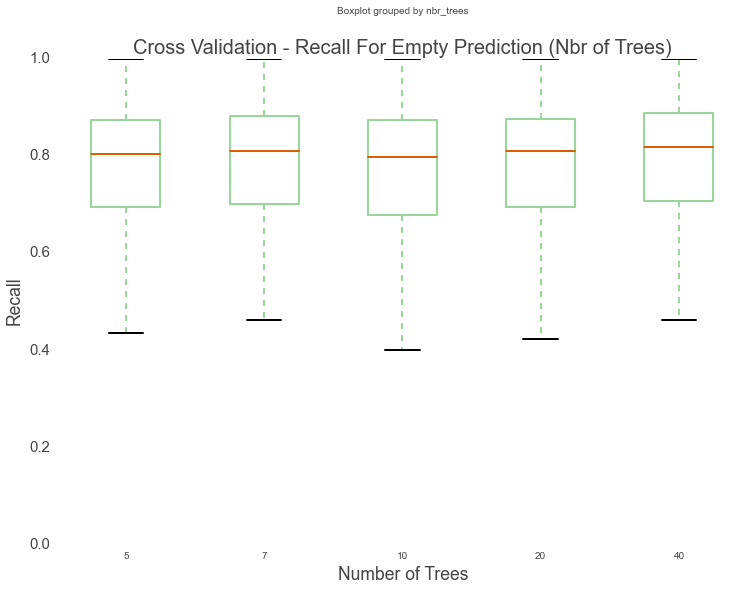

In [37]:
# Empty Station-Intervals Prediction 

# Define Train dataframe for 10 minute prediction window
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness10'])) & (~pd.isnull(reg_df_train['hist_arr']))]

# Define Number of Folds, and Nbr of Trees to Evaluate
nbr_trees = [5,7,10, 20, 40]
stations = train['station_id'].unique()
nbr_folds = 7
import warnings
warnings.filterwarnings('ignore')
#Preallocate the Crossvalidation DataFrame
crossval_recall_empty=pd.DataFrame(columns = ['station_id', 'nbr_trees', 'recall'], 
                             index = range(len(nbr_trees)*len(stations)*nbr_folds),dtype=float)
crossval_recall_empty.station_id= np.repeat(np.transpose(np.tile(stations, len(nbr_trees))), nbr_folds)
crossval_recall_empty.nbr_trees=np.repeat(nbr_trees, len(stations)*nbr_folds)

# Loop Through Different Number of Trees for each station
for ntree in nbr_trees:
    rdfrst = RandomForestClassifier(n_estimators=(ntree))
    
    #Loop through each station
    for i,station in enumerate(stations):
        X=train.loc[train.station_id == station, 
                          ['minute','weekday','precip','temp','hist_arr','hist_dep','avg_arr_10',
                           'avg_dep_10','fullness10','NBAarr','NBAdep', 'MLBarr','MLBdep']]
        Y=train.isempty[train.station_id == station]
        scores = cross_val_score(rdfrst, X,y=Y,cv=nbr_folds, scoring = 'recall')
        crossval_recall_empty.loc[(crossval_recall_empty.station_id == station) & \
                                  (crossval_recall_empty.nbr_trees == ntree), 'recall'] =scores
        #print "Station: "+str(station)+ " Ntrees: " + str(ntree)
    print "Nbr of Trees: "+str(ntree)
# Plot Distribution of Cross-validation Scores
crossval_recall_empty.boxplot(column='recall', by='nbr_trees')
plt.title('Cross Validation - Recall For Empty Prediction (Nbr of Trees)')
plt.xlabel('Number of Trees')
plt.ylabel('Recall')

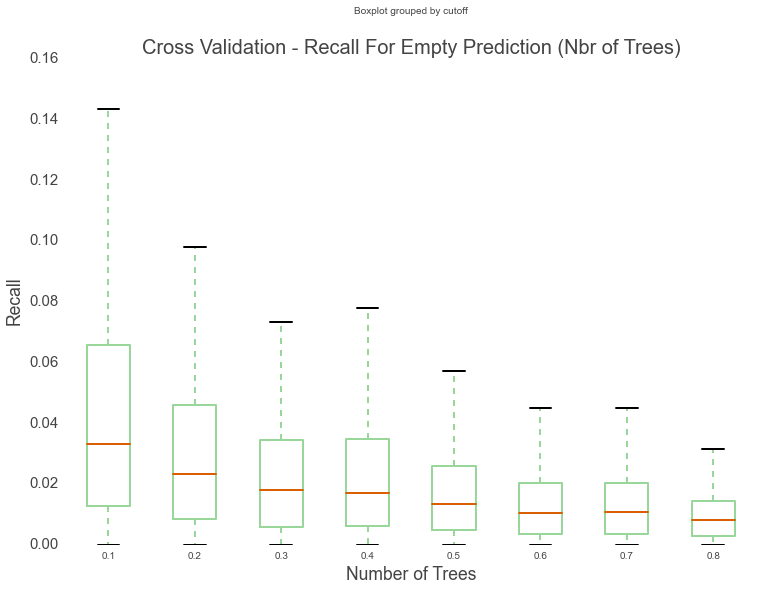

In [34]:
from IPython.display import clear_output
def cutoff_predict(clf, X,cutoff):
    probpreds = clf.predict_proba(X)
    if probpreds.shape[0] == 2:
        binary_pred = (probpreds[:,1] > cutoff)+0
    else:
        binary_pred = (probpreds[:,0] > cutoff)+0
    return binary_pred

def custom_f1(cutoff):
    def f1_cutoff(clf, X, y):
        ypred = cutoff_predict(clf, X, cutoff)
        return sklearn.metrics.f1_score(y, ypred)
    return f1_cutoff

#Determine Number of Folds and Cutoffs to evaluate over
nbr_folds = 5
cutoffs =  np.arange(0.1,0.9,0.1);
ntree = 7

#Preallocate the Crossvalidation DataFrame
crossval_f1_empty=pd.DataFrame(columns = ['station_id', 'cutoff', 'f1'], 
                               index = range(len(cutoffs)*len(stations)*nbr_folds),dtype=float)
crossval_f1_empty.station_id= np.repeat(np.transpose(np.tile(stations, len(cutoffs))), nbr_folds)
crossval_f1_empty.cutoff=np.repeat(cutoffs, len(stations)*nbr_folds)

# Loop through each cutoff
for i,cutoff in zip(xrange(len(cutoffs)), cutoffs):
    rdfrst = RandomForestClassifier(n_estimators=(ntree))
    f1_cutoff = custom_f1(cutoff)
    
    #Loop through each station
    for i,station in enumerate(stations):
        X=train.loc[train.station_id == station, 
                          ['minute','weekday','precip','temp','hist_arr','hist_dep','avg_arr_10',
                           'avg_dep_10','fullness10','NBAarr','NBAdep', 'MLBarr','MLBdep']]
        Y=train.isempty[train.station_id == station]
        scores = cross_val_score(rdfrst, X,y=Y,cv=nbr_folds, scoring=f1_cutoff)
        crossval_f1_empty.loc[(crossval_f1_empty.station_id == station) & \
                                  (crossval_f1_empty.cutoff == cutoff), 'f1'] =scores
        print "Station: "+str(i) + " Cutoff: "+str(cutoff)
clear_output()


Nbr of Trees: 5
Nbr of Trees: 7
Nbr of Trees: 10
Nbr of Trees: 20
Nbr of Trees: 40


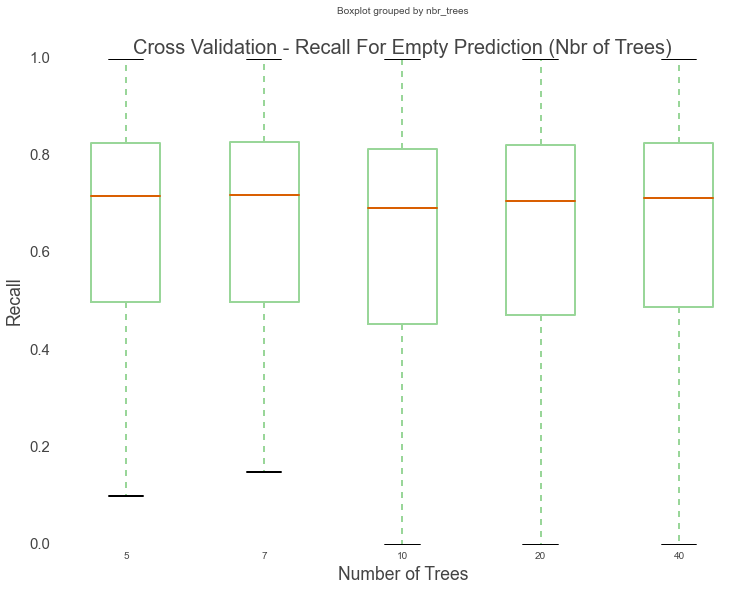

In [38]:
## Full Station-Intervals  Prediction

# Define Train dataframe for 10 minute prediction window
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness30'])) & (~pd.isnull(reg_df_train['hist_arr']))]

# Define Number of Folds, and Nbr of Trees to Evaluate
nbr_trees = [5,7,10, 20, 40]
nbr_folds = 7

#Preallocate the Crossvalidation DataFrame
crossval_recall_full=pd.DataFrame(columns = ['station_id', 'nbr_trees', 'recall'], 
                             index = range(len(nbr_trees)*len(stations)*nbr_folds),dtype=float)
crossval_recall_full.station_id= np.repeat(np.transpose(np.tile(stations, len(nbr_trees))), nbr_folds)
crossval_recall_full.nbr_trees=np.repeat(nbr_trees, len(stations)*nbr_folds)

# Loop Through Different Number of Trees for each station
for ntree in nbr_trees:
    rdfrst = RandomForestClassifier(n_estimators=(ntree))
    
    #Loop through each station
    for i,station in enumerate(stations):
        X=train.loc[train.station_id == station, ['minute','weekday','precip','temp','hist_arr','hist_dep','avg_arr_30'
                                                  ,'avg_dep_30','fullness30','NBAarr','NBAdep', 'MLBarr','MLBdep']]
        Y=train.isfull[train.station_id == station]
        scores = cross_val_score(rdfrst, X,y=Y,cv=nbr_folds, scoring = 'recall')
        crossval_recall_full.loc[(crossval_recall_full.station_id == station) & \
                                 (crossval_recall_full.nbr_trees == ntree), 'recall'] =scores
        #print "Station: "+str(station) + " Ntrees: " + str(ntree)
    print "Nbr of Trees: "+str(ntree)
    
# Plot Distribution of Cross-validation Scores        
crossval_recall_full.boxplot(column='recall', by='nbr_trees')
plt.title('Cross Validation - Recall For Empty Prediction (Nbr of Trees)')
plt.xlabel('Number of Trees')
plt.ylabel('Recall')

###3.3.2 Classifier Performance

In [39]:
## Test Scores
stations = reg_df_train['station_id'].unique()


##------------ Full Station Prediction ------------##
# Preallocate TEST recall full dataframe & Copy Train and test Dataframe
test_recall_full = pd.DataFrame(columns = ['station_id', 'week', 'hour','P_full','TP_full'])
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness30'])) & (~pd.isnull(reg_df_train['hist_arr']))]
test= reg_df_test.loc[(~pd.isnull(reg_df_test['fullness30'])) & (~pd.isnull(reg_df_test['hist_arr']))]
test['week']=(test.weekday >= 5)*1
test['TP_full']=np.nan
test['P_full']=np.nan

# Fit Classifier on Training Data as determined from cross validation and predict test data
rdfrst = RandomForestClassifier(n_estimators=7)
for i,station in enumerate(stations):
    X_train=train.loc[train.station_id == station, 
                          ['minute','weekday','precip','temp','hist_arr','hist_dep','avg_arr_30',
                           'avg_dep_30','fullness30','NBAarr','NBAdep', 'MLBarr','MLBdep']]
    Y_train=train.isfull[train.station_id == station]
    X_test= test.loc[test.station_id == station, 
                          ['minute','weekday','precip','temp','hist_arr','hist_dep','avg_arr_30',
                           'avg_dep_30','fullness30','NBAarr','NBAdep', 'MLBarr','MLBdep']]
    Y_test= test.isfull[test.station_id == station]
    
    rdfrst.fit(X_train, Y_train)
    preds = rdfrst.predict(X_test)
    test.loc[test.station_id == station, 'TP_full']=(preds & Y_test)
    test.loc[test.station_id == station, 'P_full']=Y_test
    rec_gb = test.groupby(['station_id','week','hour'],as_index=False)['P_full','TP_full'].sum()
    test_recall_full= pd.concat([test_recall_full,rec_gb])
    
    

    
##------------ Empty Station Prediction ------------##
# Preallocate TEST recall empty dataframe & Copy Train and test Dataframe
test_recall_empty = pd.DataFrame(columns = ['station_id', 'week', 'hour','P_empty','TP_empty'])
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness10'])) & (~pd.isnull(reg_df_train['hist_arr']))]
test= reg_df_test.loc[(~pd.isnull(reg_df_test['fullness10'])) & (~pd.isnull(reg_df_test['hist_arr']))]
test['TP_empty']=np.nan
test['P_empty']=np.nan
test['week']=(test.weekday >= 5)*1

# Fit Classifier on Training Data as determined from cross validation and predict test data
rdfrst = RandomForestClassifier(n_estimators=20)     
for i,station in enumerate(stations):
    X_train=train.loc[train.station_id == station, 
                          ['minute','weekday','precip','temp','hist_arr','hist_dep','avg_arr_10',
                           'avg_dep_10','fullness10','NBAarr','NBAdep', 'MLBarr','MLBdep']]
    Y_train=train.isempty[train.station_id == station]
    X_test= test.loc[test.station_id == station, 
                          ['minute','weekday','precip','temp','hist_arr','hist_dep','avg_arr_10',
                           'avg_dep_10','fullness10','NBAarr','NBAdep', 'MLBarr','MLBdep']]
    Y_test= test.isempty[test.station_id == station]
    
    rdfrst.fit(X_train, Y_train)
    preds = rdfrst.predict(X_test)
    test.loc[test.station_id == station, 'TP_empty']=(preds & Y_test)
    test.loc[test.station_id == station, 'P_empty']=Y_test
    rec_gb = test.groupby(['station_id','week','hour'],as_index=False)['P_empty','TP_empty'].sum()
    test_recall_empty= pd.concat([test_recall_empty,rec_gb])

a


In [49]:
# Aggregate and Print Scores
class_recall_full = test_recall_full[test_recall_full.week== False].groupby('hour')['TP_full','P_full'].sum()
class_recall_empty = test_recall_empty[test_recall_empty.week== False].groupby('hour')['TP_empty','P_empty'].sum()
class_recall = pd.DataFrame(columns=['Recall_full','Recall_empty'], 
index=class_recall_full.index)
class_recall.loc[:,'Recall_full']=class_recall_full.TP_full*1.0/class_recall_full.P_full*1.0
class_recall.loc[:,'Recall_empty']=class_recall_empty.TP_empty*1.0/class_recall_empty.P_empty*1.0
#class_recall.plot()
print "Recall Full: " + str(test_recall_full.TP_full.sum()*1.0/test_recall_full.P_full.sum())
print "Recall Empty: " + str(test_recall_empty.TP_empty.sum()*1.0/test_recall_empty.P_empty.sum())

Recall Full: 0.741424464697
Recall Empty: 0.814993836065


## 3.4 Bayesian Approach
<a id = '3.4'></a>
-----

Another approach for predicting whether stations will be full or empty during a given time window is the use of Bayesian analysis. Bayesian inference revises the probability of a prediction as additional evidence is acquired. Here, we simplify the computational sophistication of the analysis by assuming normality and continuity in our dataset, allowing us to use an abbreviated form of Bayesian inference: $$
\begin{eqnarray*}
\mbox{E}(\theta|y) &=& B \mu + (1-B) Y &=& \mu + (1-B)(Y-\mu)\\
B &=& \frac{\sigma^2}{\sigma^2+\tau^2}
\end{eqnarray*}
$$
In essence, this equation makes a prediction about a station partly based on the station’s historical record and partly based on the recent evidence. The variability of the more recent evidence is compared against the variability of the complete historical record to determine the extent to which each timeline factors into the prediction. While the simplicity of Bayesian analysis is often a virtue, here it is a constraint because it does not allow us to explicitly consider confounding factors such as weather and sports games. No predictive data science project would be complete without a little Bayes, however, and so here we go… 

### 3.4.1 Bayesian Prediction

In [41]:
##Create new bayes DFs
#del any preexisting bayes DFs (from multiple runs of this code) to avoid duplication errors
# del bayes
# del bayes_test
#Create new bayes DFs
bayes=reg_df_train
bayes_test=reg_df_test

##Create fullness columns in test DF

bayes_test['emptiness10']= (bayes_test['fullness10']-1)*-1

bayes=bayes[['station_id','index','weekday','daydate','month','hour','minute',
             'isfull','isempty','fullness','fullness10','fullness30']]
bayes_test=bayes_test[['station_id','index','weekday','daydate','month','hour'
                       ,'minute','emptiness10','fullness','fullness10','fullness30']]

##Use bayes to create new DFs for tau and mu
tauDF=bayes.groupby(['station_id','weekday','minute']).var()
# tauDF=tauDF[['bike_arrivals','bike_departures','latest_num_bikes','latest_capacity','isfull',
# 'isempty','fullness','fullness10','fullness20','fullness30']].reset_index()
tauDF=tauDF[['fullness']].reset_index()
tauDF.columns=['station_id','weekday','minute','fullness_tau']
muDF=bayes.groupby(['station_id','weekday','minute']).mean()
# muDF=muDF[['bike_arrivals','bike_departures','latest_num_bikes','latest_capacity','isfull',
# 'isempty','fullness','fullness10','fullness20','fullness30']].reset_index()
muDF=muDF[['fullness']].reset_index()
muDF.columns=['station_id','weekday','minute','fullness_mu']

#Merge tau and mu into test DF
bayes_test=pd.merge(bayes_test,tauDF,how='left',on=['station_id','weekday','minute'])
bayes_test=pd.merge(bayes_test,muDF,how='left',on=['station_id','weekday','minute'])

##Create new Bayes_Y column in reg_df_test to serve as small mean
bayes_test['Bayes_Y']=(bayes_test.fullness10+bayes_test.fullness30)/2
bayes_test['Bayes_S2']=bayes_test[['fullness10','fullness30']].var(axis=1)

##Create new Bayes_Beta column in test DF
bayes_test['Bayes_Beta']=bayes_test.Bayes_S2/(bayes_test.Bayes_S2+bayes_test.fullness_tau)

##Perform Bayesian analysis
bayes_test['Bayes']=bayes_test.Bayes_Beta*bayes_test.fullness_mu+(1-bayes_test.Bayes_Beta)*bayes_test.fullness10
bayes_test['Bayes_Accuracy']=bayes_test.Bayes/bayes_test.fullness

#Use Bayes_test frame to create bayes_recall df
bayes_recall=bayes_test[['station_id','weekday','hour','fullness','Bayes']]
bayes_recall['week']=np.where(bayes_recall['weekday']<5,1,0)
bayes_recall=bayes_recall[['station_id','week','hour','fullness','Bayes']]

#Create Full True Positive and False negative columns within bayes_recall Df
bayes_recall['Full True Positive']=np.where((bayes_recall['Bayes']==1)&(bayes_recall['fullness']==1),1,0)
bayes_recall['Full False Negative']=np.where((bayes_recall['Bayes']!=1)&(bayes_recall['fullness']==1),1,0)

#Create Full True Positive and False negative columns within bayes_recall Df
bayes_recall['Empty True Positive']=np.where((bayes_recall['Bayes']==0)&(bayes_recall['fullness']==0),1,0)
bayes_recall['Empty False Negative']=np.where((bayes_recall['Bayes']!=0)&(bayes_recall['fullness']==0),1,0)

#Remove NaN rows
bayes_recall=bayes_recall[pd.notnull(bayes_recall['Bayes'])]


### 3.5.2 Bayesian Performance

In [42]:
#Calculate Fullness recall for Bayes DF
Bayes_Full_TP=sum(bayes_recall['Full True Positive'])
Bayes_Full_FN=sum(bayes_recall['Full False Negative'])
BayesFullRecall=float(Bayes_Full_TP)/float(Bayes_Full_TP+Bayes_Full_FN)
print BayesFullRecall, 'Fullness Recall'

#Calculate Fullness recall for Bayes DF
Bayes_Empty_TP=sum(bayes_recall['Empty True Positive'])
Bayes_Empty_FN=sum(bayes_recall['Empty False Negative'])
BayesEmptyRecall=float(Bayes_Empty_TP)/float(Bayes_Empty_TP+Bayes_Empty_FN)
print BayesEmptyRecall, 'Emptiness Recall'

#Groupby week, hour, station
bayes_recall_grouped=bayes_recall.groupby(['station_id','week','hour']).sum().reset_index()

0.715092200551 Fullness Recall
0.675860695076 Emptiness Recall


In [43]:
bayes_recall_forplot=bayes_recall.groupby(['week','hour']).sum().reset_index()
bayes_recall_forplot['FullRecall']=bayes_recall_forplot['Full True Positive']/(bayes_recall_forplot['Full True Positive']+bayes_recall_forplot['Full False Negative'])
bayes_recall_forplot['EmptyRecall']=bayes_recall_forplot['Empty True Positive']/(bayes_recall_forplot['Empty True Positive']+bayes_recall_forplot['Empty False Negative'])
bayes_recall_forplot_Week=bayes_recall_forplot[bayes_recall_forplot['week']==1]
bayes_recall_forplot_Weekend=bayes_recall_forplot[bayes_recall_forplot['week']==0]

# plt.figure()
# plt.plot(bayes_recall_forplot_Week.hour,bayes_recall_forplot_Week.FullRecall)
# plt.plot(bayes_recall_forplot_Week.hour,bayes_recall_forplot_Week.EmptyRecall)
# plt.xlabel('Time of Day', size =20)
# plt.ylabel('Recall', size =20)
# plt.legend(['Empty: 10 min horizon','Full: 30 min horizon'],loc="lower right")
# plt.grid(color="grey", axis='y', linewidth=0.1,alpha=1)
# plt.title('Recall of Empty and Full stations - Bayesian Inference');
# plt.show()

## 3.5 Regression Approach - all Stations
<a id = '3.5'></a>
-----

We next used regression to predict station emptyness and fullness. Under this approach, we predict the number of net arrivals (arrivals - departures) during the prediction window. We explored using a variety of variables and functional forms before selecting the following:

$$Y_{i,t} = rain_{i,t} * histarr_{i,t} + avgdep_{i,t} +avgarr_{i,t} + histdep_{i,t} + histarr_{i,t} + histdep_{i,t}*empty_{i,t}+ histarr_{i,t}*full_{i,t} + MLBarr_{i,t}$$

where:
* $i$: station status interval
* $t$: horizon window
* $Y$: net bike arrivals
* $rain$: precipitation dummy (1 for >=0 inches of rain, else 0)
* $histarr$: average of historical arrivals for a given station, weekday, and interval
* $histdep$: average of historical departures for a given station, weekday, and interval
* $avgarr$: average of arrivals in the last 15 minutes for a given station and interval
* $avgdep$: average of departures in the last 15 minutes for a given station and interval
* $empty$: emptyness dummy (1 for empty, else 0)
* $full$: fullness dummy (1 for full, else 0)
* $MLBarr$: baseball dummy (1 if interval occurs within an hour before the start of a Red Sox home game and the station is one of the 4 nearest to Fenway, otherwise 0)


### 3.5.1 Regression Prediction

In [44]:
def regression_allstations(reg_df_train, reg_df_test,wind):
    
    #copy reg_df_test and reg_df_train dataframes and drop any rows with NAN
    reg_df_test2=reg_df_test.dropna(axis=0, how='any')
    reg_df_train2=reg_df_train.dropna(axis=0, how='any')

    #create dummy variable for precipitation. if raining precipdummy=1 else 0
    reg_df_train2['precipdummy']=np.zeros(len(reg_df_train2))
    reg_df_train2['precipdummy'][reg_df_train2.precip>0] = 1

    reg_df_test2['precipdummy']=np.zeros(len(reg_df_test2))
    reg_df_test2['precipdummy'][reg_df_test2.precip>0] = 1
    
    reg_df_train2['week']=(reg_df_train2['weekday'] >= 5)*1
    reg_df_test2['week']=(reg_df_test2['weekday'] >= 5)*1
    
    # Define Prediction Windows and Preallocate output variables (must be multiple of 5)
    windows = np.array(wind)

    stationids = reg_df_train2.station_id.unique().tolist()
    prevbikes_col = ['lagbikes'+str(x) for x in windows] 
    predbikes_col = ['pred_num_bikes'+str(x) for x in windows]
    reg_pred = reg_df_test2[['interv','station_id', 'week', 'hour','latest_num_bikes',
                                     'latest_capacity']+prevbikes_col]
    
    stations=reg_df_train2.station_id.unique()
    hours = reg_df_train2.hour.unique()
    week = [0,1]
    recall = pd.DataFrame(columns = ['station_id', 'week', 'hour','P_empty','P_full'],
                            index = range(len(hours)*2*len(stations)),dtype=float)

    # Preassign Station, Hour and Weekday Values
    recall.station_id = np.repeat(np.transpose(stations), len(hours)*2)
    recall.week = np.repeat(np.transpose(np.tile(week,len(stations))),len(hours))
    recall.hour = np.tile(hours, len(stations)*len(week))
    recall = recall.set_index(['station_id','week','hour'])
    
    for window in windows:
        #compute regressions for arrivals and departures for station i
        reg_netarr = smf.ols(formula= "net_arr"+str(window)+" ~ np.multiply(precipdummy,hist_arr) + avg_dep_"
                             +str(window)+" +avg_arr_"+str(window)+" + hist_dep + hist_arr +np.multiply(hist_dep,isempty"
                             +str(window)+") + np.multiply(hist_arr,isfull"+str(window)+") - 1 ", 
                             #+str(window)+") + np.multiply(hist_arr,isfull"+str(window)+")  + MLBarr - 1 ",
                             data=reg_df_train2).fit()
        
        print reg_netarr.summary()
    
        # Compute Number of Bikes accounting for station capacity
        reg_pred['pred_num_bikes'+str(window)]=np.around(reg_pred['lagbikes'+str(window)]
                                                         + reg_netarr.predict(reg_df_test2))
                
        #adjust for cases where predicted bikes is less than 0 or more than dock capacity
        reg_pred['pred_num_bikes'+str(window)][(reg_pred['pred_num_bikes'+str(window)]<0)] = 0
        reg_pred['pred_num_bikes'+str(window)][(reg_pred['pred_num_bikes'+str(window)]>
                                                 reg_pred['latest_capacity'])]= reg_pred['latest_capacity']
        
        # Calculate nbr of True Positives (Predicted Full/Empty and Actually FUll/Empty) 
        TP_empty= reg_pred[(reg_pred['latest_num_bikes']==0) & (reg_pred['pred_num_bikes'+str(window)]==0)]\
                        .groupby(['station_id','week','hour'])['week'].count()
        TP_full= reg_pred[(reg_pred['latest_num_bikes']==reg_pred['latest_capacity'])
                          & (reg_pred['pred_num_bikes'+str(window)]==reg_pred['latest_capacity'])]\
                       .groupby(['station_id','week','hour'])['week'].count()
        
        recall['TP_empty_'+str(window)]=TP_empty
        recall['TP_full_'+str(window)]=TP_full
        
    
    # Calculate nbr of Positives (Actually Full/Empty)
    recall['P_empty']= reg_pred[reg_pred['latest_num_bikes']==0]\
                                 .groupby(['station_id','week','hour'])['week'].count()
    recall['P_full']= reg_pred[reg_pred['latest_num_bikes']==reg_pred['latest_capacity']]\
                                .groupby(['station_id','week','hour'])['week'].count()
        
    recall.fillna(0, inplace=True)
    recall.reset_index(inplace=True)
    
    del reg_df_test2, reg_df_train2, reg_pred
    return recall

### 3.5.2 Regression Performance

In [50]:
reg1 = regression_allstations(reg_df_train, reg_df_test,[10,30])


                            OLS Regression Results                            
Dep. Variable:              net_arr10   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                 5.810e+04
Date:                Wed, 10 Dec 2014   Prob (F-statistic):               0.00
Time:                        21:12:23   Log-Likelihood:            -1.8570e+06
No. Observations:             2096386   AIC:                         3.714e+06
Df Residuals:                 2096379   BIC:                         3.714e+06
Df Model:                           7                                         
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
np.multiply(precipdummy, hist_arr)    -0.1669      0.005    -32.522      0.000     

In [46]:
recall_reg1 = reg1.groupby(['week','hour'])['P_empty','P_full','TP_empty_10','TP_full_30'].sum()
recall_reg1['recall_empty_10']=recall_reg1.TP_empty_10/recall_reg1.P_empty
recall_reg1['recall_full_30']=recall_reg1.TP_full_30/recall_reg1.P_full

avgrecallempty10 =recall_reg1['recall_empty_10'].mean()
avgrecallfull30 =recall_reg1['recall_full_30'].mean()

print 'Aggregate recall empty 10: ' + str(round(avgrecallempty10,2))
print 'Aggregate recall full 30: ' + str(round(avgrecallfull30,2))

Aggregate recall empty 10: 0.85
Aggregate recall full 30: 0.64


## 3.6 Regression Approach - by Station
<a id = '3.6'></a>
-----

Because the regression model above (and all of the iterations prior to that form) performed so similarly to our baseline prediction, we next tried regression by station. We hoped that by estimating a separate regression model for each station, we may be able to capture impacts associated with a station's geographic location and it's unique ridership trends. We used the same variables and functional form as above for the sake of comparison. 

### 3.6.1 Regression Prediction


In [51]:
def regression_bystation(reg_df_train, reg_df_test,wind):

    #copy reg_df_test and reg_df_train dataframes and drop any rows with NAN
    reg_df_test2=reg_df_test.dropna(axis=0, how='any')
    reg_df_train2=reg_df_train.dropna(axis=0, how='any')

    #create dummy variable for precipitation. if raining precipdummy=1 else 0
    reg_df_train2['precipdummy']=np.zeros(len(reg_df_train2))
    reg_df_train2['precipdummy'][reg_df_train2.precip>0] = 1

    reg_df_test2['precipdummy']=np.zeros(len(reg_df_test2))
    reg_df_test2['precipdummy'][reg_df_test2.precip>0] = 1
    
    reg_df_train2['week']=(reg_df_train2['weekday'] >= 5)*1
    reg_df_test2['week']=(reg_df_test2['weekday'] >= 5)*1
    
    # Define Prediction Windows and Preallocate output variables (must be multiple of 5)
    windows = np.array(wind)

    stationids = reg_df_train2.station_id.unique().tolist()
    prevbikes_col = ['lagbikes'+str(x) for x in windows] 
    predbikes_col = ['pred_num_bikes'+str(x) for x in windows]
    reg_pred = pd.DataFrame(columns=['interv','station_id', 'week', 'hour','latest_num_bikes',
                                     'latest_capacity']+prevbikes_col+predbikes_col)
    
    #loop through stations 
    for i in range(len(stationids)):
        reg_df_train3 = reg_df_train2[reg_df_train2['station_id']==stationids[i]]
        reg_df_test3 = reg_df_test2[reg_df_test2['station_id']==stationids[i]]
        
        if ((len(reg_df_train3)>0) & (len(reg_df_test3)>0)):
            
            reg_pred2=reg_df_test3[['interv','station_id', 'week', 'hour','latest_num_bikes',
                                    'latest_capacity']+prevbikes_col]
            
            for window in windows:
                #compute regressions for arrivals and departures for station i
                reg_netarr = smf.ols(formula= "net_arr"+str(window)+" ~ np.multiply(precipdummy,hist_arr) + avg_dep_"
                                     +str(window)+" +avg_arr_"+str(window)+" + hist_dep + hist_arr +np.multiply(hist_dep,isempty"
                                     +str(window)+") + np.multiply(hist_arr,isfull"+str(window)+")  + MLBarr - 1 ", 
                                     data=reg_df_train3).fit()

                #compute predicted number of bikes as prevbikes + predicted arrivals - predicted departures
                reg_pred2['pred_num_bikes'+str(window)]=np.around(reg_df_test3['lagbikes'+str(window)] 
                                                                  + reg_netarr.predict(reg_df_test3))
                
                #adjust for cases where predicted bikes is less than 0 or more than dock capacity
                reg_pred2['pred_num_bikes'+str(window)][(reg_pred2['pred_num_bikes'+str(window)]<0)] = 0
                reg_pred2['pred_num_bikes'+str(window)][(reg_pred2['pred_num_bikes'+str(window)]>
                                                         reg_pred2['latest_capacity'])]= reg_pred2['latest_capacity']

            #append the dataframe for station i to the dataframe for all stations
            reg_pred=pd.concat([reg_pred,reg_pred2])
    
    stations=reg_pred.station_id.unique()
    hours = reg_pred.hour.unique()
    week = [0,1]
    recall = pd.DataFrame(columns = ['station_id', 'week', 'hour','P_empty','P_full'],
                            index = range(len(hours)*2*len(stations)),dtype=float)

    # Preassign Station, Hour and Weekday Values
    recall.station_id = np.repeat(np.transpose(stations), len(hours)*2)
    recall.week = np.repeat(np.transpose(np.tile(week,len(stations))),len(hours))
    recall.hour = np.tile(hours, len(stations)*len(week))
    recall = recall.set_index(['station_id','week','hour'])
    
    # Calculate nbr of Positives (Actually Full/Empty)
    recall['P_empty']= reg_pred[reg_pred['latest_num_bikes']==0]\
                                 .groupby(['station_id','week','hour'])['week'].count()
    recall['P_full']= reg_pred[reg_pred['latest_num_bikes']==reg_pred['latest_capacity']]\
                                .groupby(['station_id','week','hour'])['week'].count()
        
    # Loop through each Prediction Window
    for window in windows:
        
        # Calculate nbr of True Positives (Predicted Full/Empty and Actually FUll/Empty) 
        TP_empty= reg_pred[(reg_pred['latest_num_bikes']==0) & (reg_pred['pred_num_bikes'+str(window)]==0)]\
                        .groupby(['station_id','week','hour'])['week'].count()
        TP_full= reg_pred[(reg_pred['latest_num_bikes']==reg_pred['latest_capacity'])
                          & (reg_pred['pred_num_bikes'+str(window)]==reg_pred['latest_capacity'])]\
                       .groupby(['station_id','week','hour'])['week'].count()
        
        recall['TP_empty_'+str(window)]=TP_empty
        recall['TP_full_'+str(window)]=TP_full

    recall.fillna(0, inplace=True)
    recall.reset_index(inplace=True)
    
    del reg_df_test2, reg_df_test3, reg_df_train2, reg_df_train3, reg_pred
    return recall


### 3.6.2 Regression Performance

In [52]:
reg2 = regression_bystation(reg_df_train,reg_df_test,[10,30])

recall_reg2 = reg2.groupby(['week','hour'])['P_empty','P_full','TP_empty_10','TP_full_30'].sum()
recall_reg2['recall_empty_10']=recall_reg2.TP_empty_10/recall_reg2.P_empty
recall_reg2['recall_full_30']=recall_reg2.TP_full_30/recall_reg2.P_full

avgrecallempty10 =recall_reg2['recall_empty_10'].mean()
avgrecallfull30 =recall_reg2['recall_full_30'].mean()

print 'Aggregate recall empty 10: ' + str(round(avgrecallempty10,2))
print 'Aggregate recall full 30: ' + str(round(avgrecallfull30,2))



Aggregate recall empty 10: 0.85
Aggregate recall full 30: 0.64


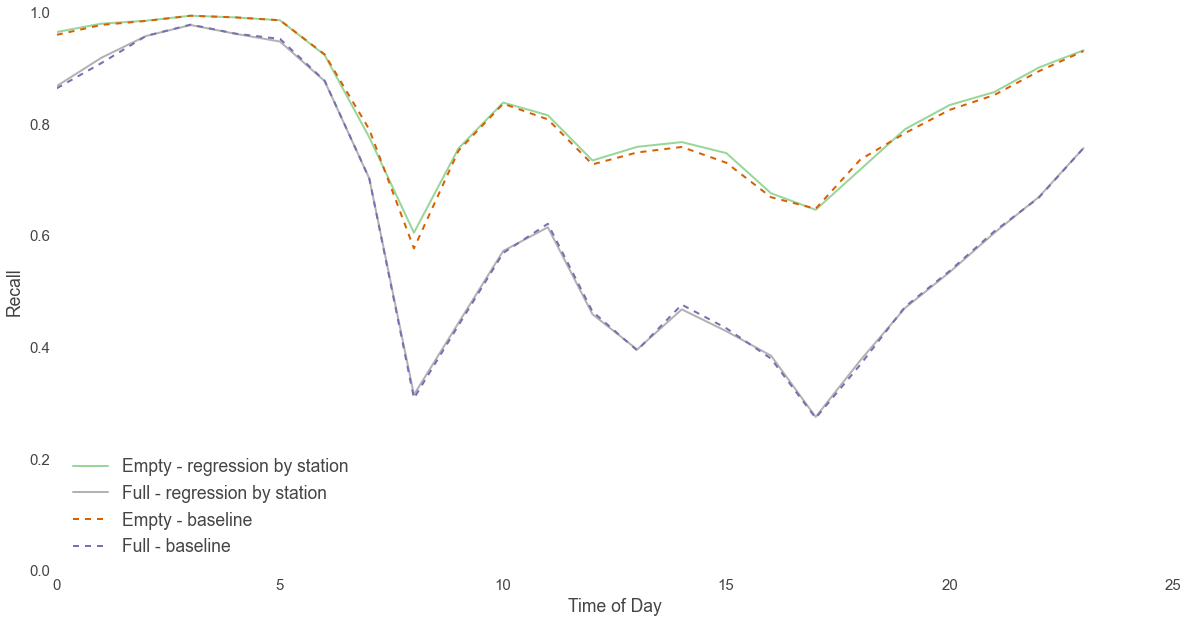

In [53]:
#regression performance
reg2 = regression_bystation(reg_df_train,reg_df_test,[10,30])
recall_reg = reg2.groupby(['week','hour'])['P_empty','P_full','TP_empty_10','TP_full_30'].sum()
recall_reg['recall_empty_10']=recall_reg.TP_empty_10/recall_reg.P_empty
recall_reg['recall_full_30']=recall_reg.TP_full_30/recall_reg.P_full

#baseline performance
res_test = baseline(reg_df_test,[10,30])
recall_base = res_test.groupby(['week','hour'])['P_empty','P_full','TP_empty_10','TP_full_30'].sum()
recall_base['recall_empty_10']=recall_base.TP_empty_10/recall_base.P_empty
recall_base['recall_full_30']=recall_base.TP_full_30/recall_base.P_full

plt.figure(figsize=(20,10));
recall_reg.loc[0, 'recall_empty_10'].plot('Empty - regression by station');
recall_reg.loc[0, 'recall_full_30'].plot('Full - regression by station');
recall_base.loc[0, 'recall_empty_10'].plot('Empty - baseline', linestyle='--');
recall_base.loc[0, 'recall_full_30'].plot('Full - baseline', linestyle='--');
plt.ylim(0,1);
plt.xlabel('Time of Day');
plt.ylabel('Recall');
plt.legend( loc='lower left');


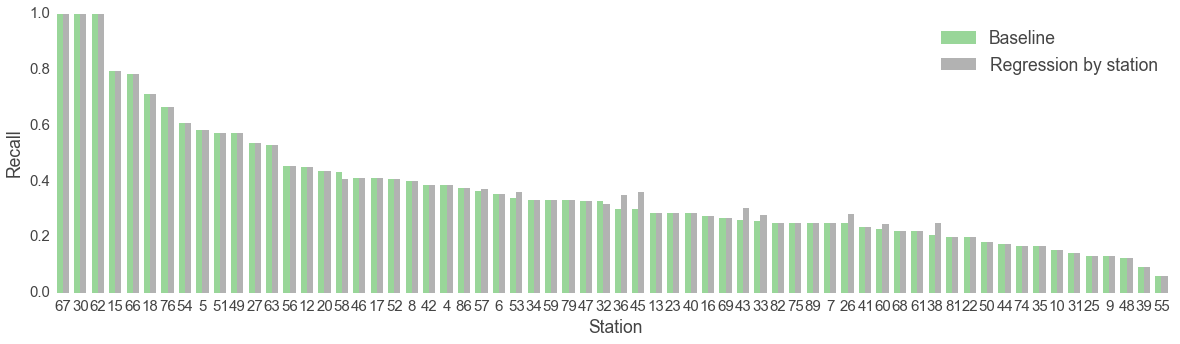

In [54]:
#regression performance
#reg2 = regression_bystation(reg_df_train,reg_df_test,[10,30])
recall_reg_st = reg2.loc[reg2.hour.between(16,18)].groupby(['station_id','week'],as_index=False)['P_empty','P_full','TP_empty_10','TP_full_30'].sum()
#recall_reg_st = reg2.groupby(['station_id','week'],as_index=False)['P_empty','P_full','TP_empty_10','TP_full_30'].sum()
recall_reg_st['recall_empty_10']=recall_reg_st.TP_empty_10/recall_reg_st.P_empty
recall_reg_st['recall_full_30']=recall_reg_st.TP_full_30/recall_reg_st.P_full

#baseline performance
#res_test = baseline(reg_df_test,[10,30])
recall_base_st = res_test.loc[res_test.hour.between(16,18)].groupby(['station_id','week'],as_index=False)['P_empty','P_full','TP_empty_10','TP_full_30'].sum()
#recall_base_st = res_test.groupby(['station_id','week'],as_index=False)['P_empty','P_full','TP_empty_10','TP_full_30'].sum()
recall_base_st['recall_empty_10']=recall_base_st.TP_empty_10/recall_base_st.P_empty
recall_base_st['recall_full_30']=recall_base_st.TP_full_30/recall_base_st.P_full

reg_compare = pd.merge(recall_reg_st, recall_base_st, on=['station_id','week'])
reg_compare_wd = reg_compare[(reg_compare['recall_full_30_y']>0) & (reg_compare['week']==0)].sort('recall_full_30_y', ascending=0)
#print reg_compare[(reg_compare['recall_full_30_y']>0) & (reg_compare['week']==0)].sort('P_full_x', ascending=0).head(10) 

N = len(reg_compare_wd.station_id.unique())
ind = np.arange(N)  # the x locations for the groups
width = .35      # the width of the bars
fig, ax = plt.subplots(figsize=(20,5))
#rects1 = ax.bar(ind, reg_compare_wd.recall_full_30_y, width)
#rects2 = ax.bar(ind+width, reg_compare_wd.recall_full_30_x, width)
rects1 = ax.bar(ind, reg_compare_wd.recall_full_30_y, width, color=dark_colors[0])
rects2 = ax.bar(ind+width, reg_compare_wd.recall_full_30_x, width,color=dark_colors[1])

ax.set_ylabel('Recall');
ax.set_xlabel('Station');
ax.set_xticks(ind+width);
ax.set_xticklabels( np.array(reg_compare_wd.station_id).astype(int));
ax.set_xlim([0,N]);
ax.legend( (rects1[0], rects2[0]), ('Baseline', 'Regression by station') );


#4 Conclusions
<a id = '4'></a>
-----

For this project, we sought to predict the occurrence of empty and full Hubway stations. The methods we used were:

* Baseline: real-time station status is maintained through prediction horizon, meaning that predictions for the near-future are entirely based on each station’s current state

* Two random forest classifiers: (1) empty/not empty and (2) full/not full

* Bayesian inference:  predicted fullness in terms of bikes/capacity, which was then transformed into binary clases of full/not full and empty/not empty

* Regression: predicted net bike arrivals, translated into the probability of a station being empty or full


##4.1 Performance
<a id = '4.1'></a>
-----

We use recall to evaluate and compare the performance of each model against the Baseline, where $TP$ is correctly predicting empty/full stations as empty/full, and $FN$ is incorrectly predicting empty/full stations as not empty/not full:

$$\begin{eqnarray*}
\mbox{recall} &=& { TP / (TP + FN) }
\end{eqnarray*}$$

Recall is chosen as our accuracy metric rather than precision because false positives (incorrrectly predicting not empty/not full stations as empty/full) are less relevant than false negatives in this application. This is due to the fact that riders would rely on such predictions to make decisions about going to particular stations. If we tell them a station will not be empty/not full, and they arrive to an empty/full station, they are turned away. This is precisely the scenario captured by recall. Conversely, if we predict a station as full or empty when it is not, riders are not turned away and are likely to not even be aware of such a misclassification. Precision would be a secondary metric to evaluate the extent to which riders are incorrectly directed away from the station.

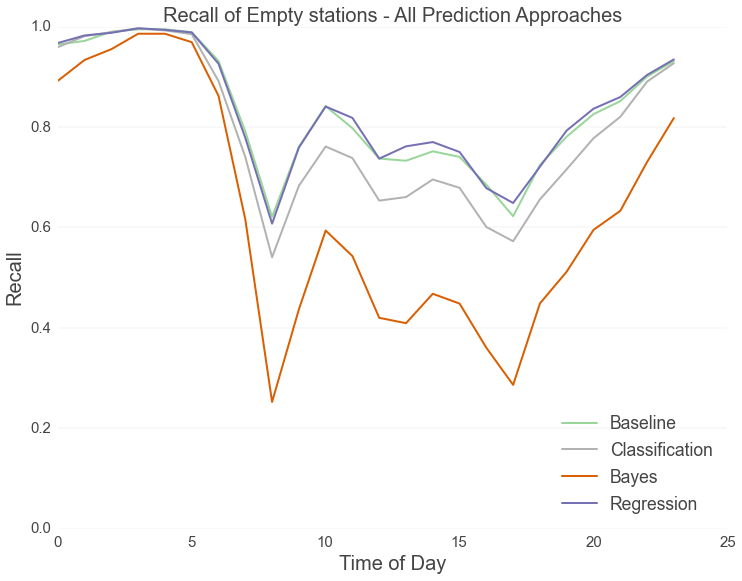

In [61]:
# RECALL EMPTY
recall.loc[0, 'recall_empty_10'].plot()
class_recall['Recall_empty'].plot()
plt.plot(bayes_recall_forplot_Week.hour,bayes_recall_forplot_Week.EmptyRecall)
recall_reg.loc[0, 'recall_empty_10'].plot();

plt.ylim(0,1)
plt.xlabel('Time of Day', size =20)
plt.ylabel('Recall', size =20)
plt.legend(['Baseline','Classification','Bayes','Regression'],loc="lower right")
plt.grid(color="grey", axis='y', linewidth=0.1,alpha=1)
plt.title('Recall of Empty stations - All Prediction Approaches');

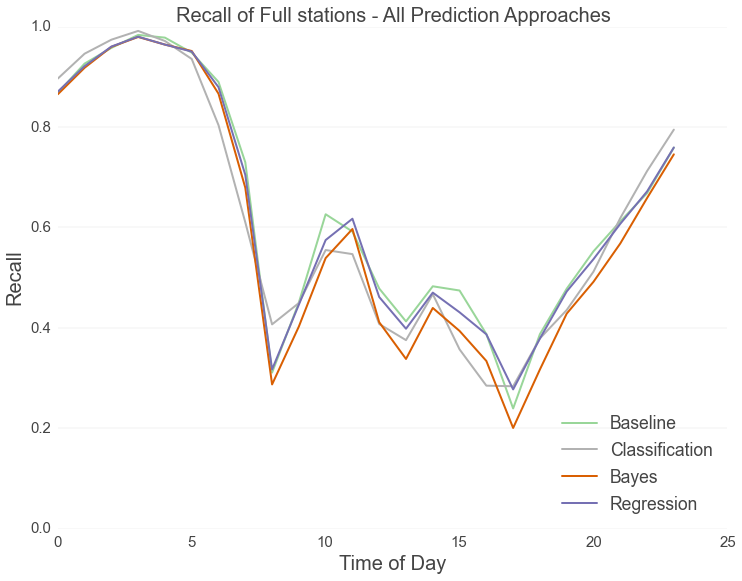

In [62]:
# RECALL FULL
plt.figure()
recall.loc[0, 'recall_full_30'].plot()
class_recall['Recall_full'].plot()
plt.plot(bayes_recall_forplot_Week.hour,bayes_recall_forplot_Week.FullRecall)
recall_reg.loc[0, 'recall_full_30'].plot();

plt.ylim(0,1)
plt.xlabel('Time of Day', size =20)
plt.ylabel('Recall', size =20)
plt.legend(['Baseline','Classification','Bayes','Regression'],loc="lower right")
plt.grid(color="grey", axis='y', linewidth=0.1,alpha=1)
plt.title('Recall of Full stations - All Prediction Approaches');

###4.1.1. Random Forest Classification
The random forest classification approach was explored for different number of trees and more for different cut-off values. The fundamental issue with this approach is that the two classes (empty/not-empty and full/not-full) for each classifier are too imbalanced. Hence, the cut-off value would need to be adjusted too close to 0 in-order to account for this imbalance. A possible alternative to this issue would be to over-sample the intervals with full and empty stations in order to avoid having to adjust the cut-off.   

###4.1.2. Bayesian Inference
The bayesian inference model performed less accurately than our other prediction methods, including the baseline model. This is partly due to the mechanism underlying the bayesian analysis. By definition, the model balances between predicting based on each station’s complete history of emptiness and fullness and its more recent 30 minute history. The precise balance depends upon the variability in fullness over the past half an hour relative to the variability over the entire history. Stations that are likely to fill up are also likely to be more variable in the short term (because there is an influx of bicycles), yet this causes the model to mistakenly put less emphasis on the short term and instead emphasize the long term history. Moreover, one of the model’s simplifying assumptions is likely false: we assumed that the data followed a normal distribution, but upon further exploration discovered that station departures and arrivals may instead follow a poisson distribution. Future iterations of this model could revisit the models potentially flawed design and assumptions.

###4.1.3. Regression
After exploring many different combinations of variables and model structure, the regression model performs very similarly to our baseline prediction (note that predicting zero net arrivals is equivalent to the Baseline model). This result is due in large part to imbalanced data, in that there are not enough station status intervals for which the net arrivals is large in magnitude, causing two issues:
* by minimizing the error to all points, the model overwhelming predicts very small net arrivals at the expense of the outlier stations and/or intervals
* the predictive power of variables is hard to capture when most net arrivals are very small regardless of rain, time of day, events, etc...



##4.2 Next Steps
<a id = '4.2'></a>
-----

Given our understanding of the limitations of each model (as discussed above), next steps would include improving on one or more of these models, or doing an ensemble approach. Moreover, we suggest refining each component analysis by incorporating new variables, such as data on trips and user demographics, and by refining existing training datasets to more closely analyze scenarios in which empty and full stations are likely (e.g., look more closely at chronic problem stations, time periods with bad weather, popular events).

If enough predictive improvement can be made over the Baseline model to warrant further analysis, this work can be the foundation for a real-time prediction platform. This platform could be a simple web application that spatially displays predicted numbers of bikes and docks across each Hubway station for near-term horizons. This could serve both Hubway and its users by better informing them of likely rebalancing needs in the near-term, as well as improve user experience and satisfaction with the system as they can better avoid being turned away from empty and full stations.